# Title Page

Dataset Title: Satellite Image Classification

Module Code: KV6021

Module Name: Machine Learning

Student Name: Shi Haw Ng

Student Number: W22027467

Programme: BSC (HONS) Computer Science with Artificial Intelligence

Word Count: 1592



# Import Libraries / Packages

In [1]:
%reset -f

In [2]:
!pip install keras-tuner #Install tuner for VGG16

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 9.0 MB/s eta 0:00:00


In [3]:
from google.colab import drive
import os
import numpy as np
import keras_tuner as kt
import cv2
import warnings
warnings.filterwarnings('ignore') # to ignore any warning you might see in the code
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.applications import VGG16
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, roc_auc_score, precision_recall_curve, auc, average_precision_score, top_k_accuracy_score
from sklearn.preprocessing import label_binarize
from sklearn.svm import SVC
from keras_tuner.tuners import RandomSearch

## Check GPU Availability

In [4]:
# Check if GPU is available
if tf.test.gpu_device_name():
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
else:
    print("Please install GPU version of TF")

# Set memory growth to avoid allocating all GPU memory
physical_devices = tf.config.list_physical_devices('GPU')
try:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
except Exception as e:
    # Invalid device or cannot modify virtual devices once initialized.
    print(e)

# Check if GPU is being used
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Default GPU Device: /device:GPU:0
Num GPUs Available:  1


## Mount Google Drive

In [5]:
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


# Dataset Preparation

In [6]:
# Load data (~1-3mins)
data_dir = '/content/drive/MyDrive/data'  # UPDATE this path
class_names = sorted(os.listdir(data_dir))  # 4 classes in for this project
img_size = 64

image, labels = [], []
total_images = sum(len(files) for _, _, files in os.walk(data_dir)) # Get total number of images

with tqdm(total=total_images, desc="Loading Images") as pbar: # Progress bar setup
  for idx, class_name in enumerate(class_names):
      class_path = os.path.join(data_dir, class_name)
      for img_file in os.listdir(class_path):
          img_path = os.path.join(class_path, img_file)
          # Load image in color (RGB) using cv2.IMREAD_COLOR
          img = cv2.imread(img_path, cv2.IMREAD_COLOR)

          if img is not None:
              # Convert from BGR (OpenCV default) to RGB
              img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
              img = cv2.resize(img, (img_size, img_size))
              image.append(img)
              labels.append(idx)
          pbar.update(1)

# Display total number of images loaded
print(f"\n\nTotal number of images loaded: {total_images}")

#Preprocess dataset
image = np.array(image)
label = np.array(labels)

label_map = {
    0: "Cloudy",
    1: "Desert",
    2: "Green_Area",
    3: "Water"
}

Loading Images: 100%|██████████| 5631/5631 [02:28<00:00, 37.87it/s] 



Total number of images loaded: 5631


# Exploratory Data Analysis (**EDA**)


## Data Visualization

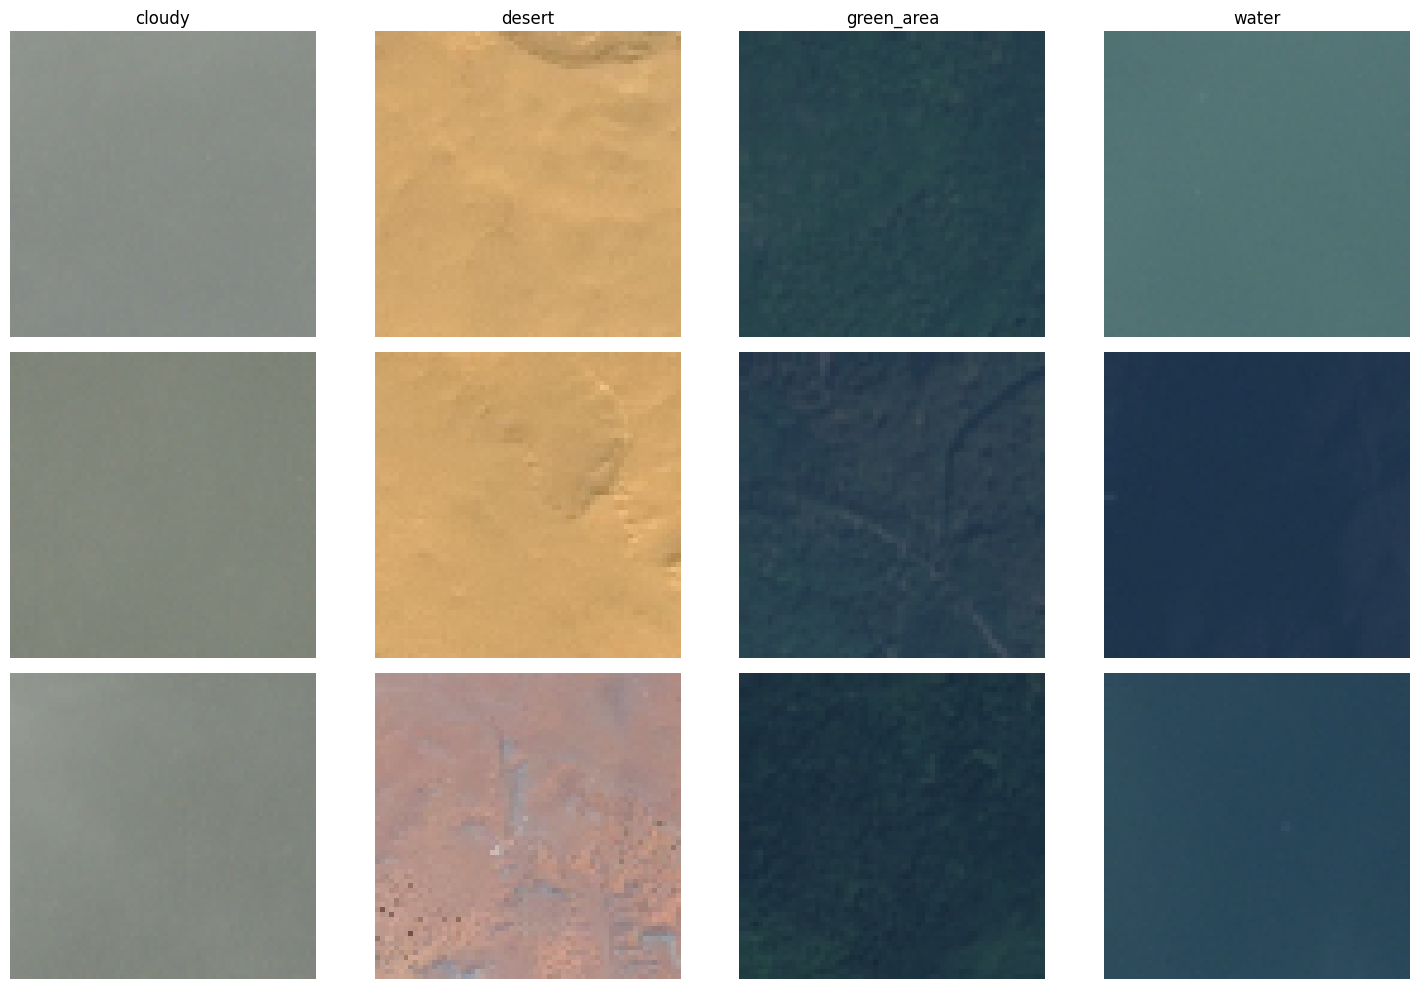

In [7]:
# Display sample images
def visualize_samples(image_data, image_labels, class_names, num_samples=1):
    fig, axes = plt.subplots(num_samples, len(class_names), figsize=(15, 10))
    # Check if axes is 1-dimensional (num_samples=1 case)
    if num_samples == 1:
        axes = axes.reshape(1, -1)  # Reshape to 2D for consistent indexing


    for i, class_name in enumerate(class_names):
        # Get random indices for the current class
        idxs = np.where(image_labels == i)[0]
        # If idxs exist, choose random samples, otherwise skip
        if idxs.size > 0:
            idxs = np.random.choice(idxs, size=num_samples, replace=False)
        else:
            continue
        for j, idx in enumerate(idxs):
            axes[j, i].imshow(image_data[idx])
            axes[j, i].axis('off')
            if j == 0:
                axes[j, i].set_title(class_name)

    plt.tight_layout()
    plt.show()


# Visualize 3 random samples from each class
visualize_samples(image, label, class_names, num_samples=3)

## Class Distribution Visualization


A critical aspect of the EDA was the analysis of the class distribution. The number of images belonging to each class was counted, and this distribution was visualized using a bar plot generated with the seaborn library. This analysis revealed that Desert class has lower image counts compared to the other classes. Understanding the class distribution is vital as imbalanced datasets can lead to models that are biased towards the majority class, potentially resulting in poor performance on minority classes.

Calculating Class Distribution: 100%|██████████| 4/4 [00:00<00:00, 8853.41it/s]



Class 'cloudy': 1500 images
Class 'desert': 1131 images
Class 'green_area': 1500 images
Class 'water': 1500 images


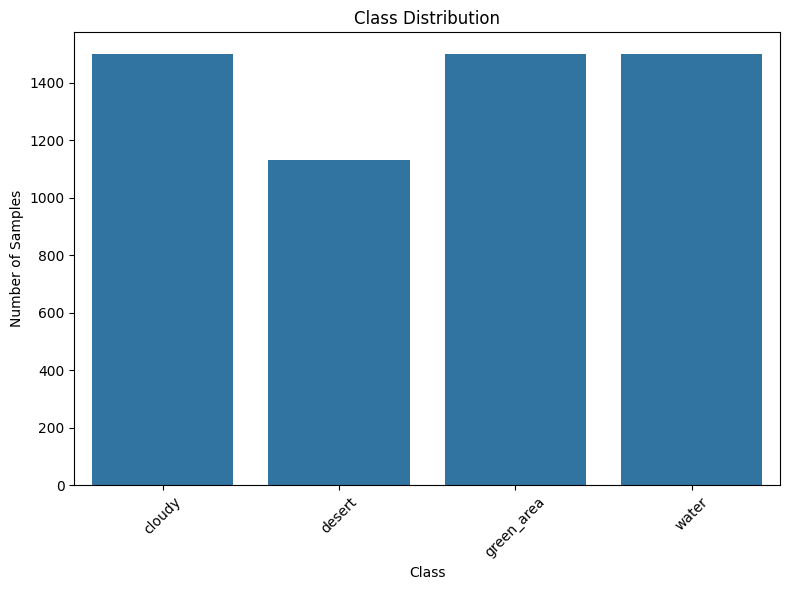

In [8]:
class_counts = []
for i in tqdm(range(len(class_names)), desc="Calculating Class Distribution"):
    count = np.sum(label == i)
    class_counts.append(count)

print('\n')

# Print the class counts after the loop finishes
for i in range(len(class_names)):
    print(f"Class '{class_names[i]}': {class_counts[i]} images")

# Plotting
plt.figure(figsize=(8, 6))
sns.barplot(x=class_names, y=class_counts)
plt.title("Class Distribution")
plt.xlabel("Class")
plt.ylabel("Number of Samples")
plt.xticks(rotation=45)  # Optional: improves readability if names are long
plt.tight_layout()
plt.show()

## Characterization of the Dataset

The dataset contains image files stored as NumPy arrays. Before processing, the images were uint8 with pixel values from 0 to 255, and there were no missing values. The shape of the data showed the number of images, their size, and color channels. Statistics like minimum, maximum, mean, and standard deviation of pixel values are calculated to understand the data before normalization.

In [9]:
# Label information
print("--- Label Information ---")
unique_labels, label_counts = np.unique(label, return_counts=True)

print("Unique labels and class names:")
for lbl, count in zip(unique_labels, label_counts):
    class_name = label_map.get(lbl, "Unknown")
    print(f"Label {lbl} ({class_name}): {count} samples")

# Basic missing value checks
print("\nMissing Values in images:", np.sum(np.isnan(image)))
print("Missing Values in labels:", np.sum(np.isnan(label)))

# Shape and data type
print("Image data type:", image.dtype)
print("Image shape:", image.shape)
print("Label data type:", label.dtype)
print("Label shape:", label.shape)

# Detailed statistics for image data
print("\n--- Image Statistics ---")
print("Minimum pixel value:", np.min(image))
print("Maximum pixel value:", np.max(image))
print("Mean of pixel values:", np.mean(image))
print("Standard deviation of pixel values:", np.std(image))
print("Median pixel value:", np.median(image))
print("Pixel value range:", np.ptp(image))  # Peak to peak (max - min)

# Channel-wise statistics if image has 3 or more dimensions (e.g., RGB images)
if len(image.shape) >= 4:  # (samples, height, width, channels)
    channels = image.shape[-1]
    for i in range(channels):
        print(f"\nChannel {i} statistics:")
        print(f"  Min: {np.min(image[:, :, :, i])}")
        print(f"  Max: {np.max(image[:, :, :, i])}")
        print(f"  Mean: {np.mean(image[:, :, :, i])}")
        print(f"  Std: {np.std(image[:, :, :, i])}")

--- Label Information ---
Unique labels and class names:
Label 0 (Cloudy): 1500 samples
Label 1 (Desert): 1131 samples
Label 2 (Green_Area): 1500 samples
Label 3 (Water): 1500 samples

Missing Values in images: 0
Missing Values in labels: 0
Image data type: uint8
Image shape: (5631, 64, 64, 3)
Label data type: int64
Label shape: (5631,)

--- Image Statistics ---
Minimum pixel value: 4
Maximum pixel value: 255
Mean of pixel values: 107.32488801586179
Standard deviation of pixel values: 53.692623403783855
Median pixel value: 98.0
Pixel value range: 251

Channel 0 statistics:
  Min: 4
  Max: 255
  Mean: 102.34725819369062
  Std: 67.87695398798178

Channel 1 statistics:
  Min: 15
  Max: 255
  Mean: 110.30080115064764
  Std: 50.970381302070095

Channel 2 statistics:
  Min: 13
  Max: 255
  Mean: 109.32660470324709
  Std: 37.493906756268025


## Formalisation of the Task


Based on the EDA, the task is a multi-class image classification problem with four categories. The goal is to build models that predict the correct class. Depending on whether the class distribution was balanced or not, the task might also involve addressing class imbalance. The rest of the report will cover the different models used for this task.

4 models were selected for this project, 2 from Deep Learning and 2 from Machine Learning.


1.   Deep Learning
    *   Custom Convolutional Neural Network (CNN)
    *   VGG16 with Keras Tuner (RandomSearchCV)
2.   Machine Learning
    *   KMeans Clustering with Principal Component Analysis (PCA)
    *   Support Vector Machine (SVM) with GridSearchCV

# Literature Review

1. **Support Vector Machine (SVM) with GridSearchCV**

Support Vector Machine (SVM) is a supervised learning algorithm widely recognized for its effectiveness in high-dimensional classification tasks. It operates by identifying an optimal hyperplane that maximizes the margin between data points of different classes. SVM has been extensively used in remote sensing and satellite image classification due to its robustness and accuracy, particularly in scenarios involving limited training data (Mountrakis et al., 2011).

Hyperparameter tuning plays a crucial role in enhancing SVM performance. GridSearchCV is employed in this project to systematically evaluate a predefined set of parameters (e.g., kernel type, regularization parameter
𝐶 C, and kernel coefficient 𝛾 γ). This exhaustive search method ensures optimal model performance, albeit at the cost of increased computational time.

Advantages:

*  Performs well in high-dimensional spaces.
*  Effective with limited, well-separated data.
*  Kernel trick allows non-linear decision boundaries.

Limitations:

*  Computationally intensive for large datasets.
*  Sensitive to choice of kernel and parameter settings.

SVM serves as a strong baseline model, providing a benchmark for comparing the performance of more complex deep learning methods.

2. **KMeans Clustering with Principal Component Analysis (PCA)**

KMeans is an unsupervised clustering algorithm that partitions data into
𝑘 k clusters based on feature similarity. While not a classifier in the traditional sense, KMeans can be used for pre-classification analysis, unsupervised pattern discovery, and data segmentation. When combined with PCA, which reduces the dimensionality of the dataset by transforming it into a set of orthogonal components, KMeans becomes more efficient and less prone to noise.

This technique is particularly useful in the exploratory phase, offering insights into inherent data structures and potential separability among classes (Jain, 2010).

Advantages:

* Simple and fast for clustering.
* PCA aids in noise reduction and visualization.
* Can reveal latent patterns in the data.

Limitations:

* Assumes clusters are spherical and of similar size.
* PCA may discard non-linear but important information.
* Not suitable as a standalone classifier.

In this project, KMeans with PCA was used to analyze the feature distribution and to support dimensionality reduction before applying supervised models.

3. **Custom Convolutional Neural Network (CNN)**

Convolutional Neural Networks (CNNs) are the foundation of modern image classification. CNNs consist of convolutional layers that learn spatial hierarchies, pooling layers that reduce dimensionality, and fully connected layers for classification. They automatically learn relevant features from raw image data without the need for manual feature engineering.

The custom CNN architecture designed for this project includes four convolutional blocks with increasing filter sizes (64 to 512), Batch Normalization, LeakyReLU activation functions, and a Global Average Pooling layer, followed by dense layers with a softmax output for multi-class classification.

Advantages:

* Learns spatial features automatically.
* Scalable and flexible for varying image sizes.
* Performs well with sufficient training data.

Limitations:

* Computationally expensive.
* Requires substantial training data to avoid overfitting.
* Less interpretable compared to classical models.

The custom CNN in this project serves as a core model, trained from scratch to adapt to the specific characteristics of the dataset.

4. **VGG16 with Keras Tuner (RandomSearchCV)**

VGG16 is a deep CNN architecture pre-trained on the ImageNet dataset, commonly used in transfer learning. Its architecture consists of 13 convolutional layers and 3 fully connected layers, using small 3×3 3×3 filters and a uniform structure that simplifies implementation.

Transfer learning using VGG16 enables the model to leverage learned features from large-scale natural image datasets, reducing training time and improving accuracy, especially when the available data is limited.

To optimize the model, Keras Tuner with RandomSearchCV is used. Random Search is a more efficient alternative to grid search for high-dimensional hyperparameter spaces. It randomly samples combinations of parameters, often achieving comparable results with significantly fewer iterations.

Advantages:

* Transfer learning accelerates training and improves accuracy.
* Well-established architecture with proven performance.
* Hyperparameter tuning enhances generalization.

Limitations:
* High memory and computational requirements.
* May not capture domain-specific features if not fine-tuned adequately.

VGG16, with hyperparameter tuning, provides a high-performing alternative to the custom CNN and is especially effective when computational resources allow for transfer learning.

# Pre-processing

Image data underwent pre-processing to prepare it for model input. Pixel intensities were normalized by scaling the range from [0, 255] to [0, 1]. This standardization aids model training. For traditional machine learning models, images were flattened from their multi-dimensional format into 1D vectors. The dataset was then partitioned into 80% for training and 20% for testing using train_test_split with a fixed random_state for reproducibility. This split was applied separately for flattened and original data. The number of samples in each split was verified.

In [10]:
# Preprocess dataset
image = np.array(image) / 255.0 # Normalize to [0,1]

In [11]:
# Detailed statistics for image data
print("\n--- Image Statistics ---")
print("Minimum pixel value:", np.min(image))
print("Maximum pixel value:", np.max(image))
print("Mean of pixel values:", np.mean(image))
print("Standard deviation of pixel values:", np.std(image))
print("Median pixel value:", np.median(image))
print("Pixel value range:", np.ptp(image))  # Peak to peak (max - min)

# Channel-wise statistics if image has 3 or more dimensions (e.g., RGB images)
if len(image.shape) >= 4:  # (samples, height, width, channels)
    channels = image.shape[-1]
    for i in range(channels):
        print(f"\nChannel {i} statistics:")
        print(f"  Min: {np.min(image[:, :, :, i])}")
        print(f"  Max: {np.max(image[:, :, :, i])}")
        print(f"  Mean: {np.mean(image[:, :, :, i])}")
        print(f"  Std: {np.std(image[:, :, :, i])}")


--- Image Statistics ---
Minimum pixel value: 0.01568627450980392
Maximum pixel value: 1.0
Mean of pixel values: 0.4208819137876951
Standard deviation of pixel values: 0.21055930746581833
Median pixel value: 0.3843137254901961
Pixel value range: 0.9843137254901961

Channel 0 statistics:
  Min: 0.01568627450980392
  Max: 1.0
  Mean: 0.4013617968380023
  Std: 0.266184133286203

Channel 1 statistics:
  Min: 0.058823529411764705
  Max: 1.0
  Mean: 0.43255216137508706
  Std: 0.19988384824341213

Channel 2 statistics:
  Min: 0.050980392156862744
  Max: 1.0
  Mean: 0.42873178314998867
  Std: 0.14703492845595292


In [12]:
# Flatten for classical ML
image_data_flat = image.reshape((image.shape[0], -1))

with tqdm(total=2, desc="Data Splitting") as pbar:
    # Machine Learning Data Split
    image_train_svm, image_test_svm, label_train_svm, label_test_svm = train_test_split(image_data_flat, label, test_size=0.2, random_state=42)
    pbar.update(1)  # Update after ML split

    # Deep Learning Data Split
    image_train, image_test, label_train, label_test = train_test_split(image, label, test_size=0.2, random_state=42)
    pbar.update(1)  # Update after DL split

# Print the results
print("\n\nMachine Learning Data Split:")
print("Training images:", image_train_svm.shape[0])
print("Testing images:", image_test_svm.shape[0])

print("\nDeep Learning Data Split:")
print("Training images:", image_train.shape[0])
print("Testing images:", image_test.shape[0])

Data Splitting: 100%|██████████| 2/2 [00:00<00:00,  6.35it/s]



Machine Learning Data Split:
Training images: 4504
Testing images: 1127

Deep Learning Data Split:
Training images: 4504
Testing images: 1127


# Deep Learning Model

### Define callbacks

In [13]:
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=3, min_lr=1e-6)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

## 1. CNN Model

### Building Model

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 64, 64, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 32, 32, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 16, 16, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 16, 16, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 16384)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     8,389,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │         2,052 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,536,580 (36.38 MB)

 Trainable params: 9,536,580 (36.38 MB)

 Non-trainable params: 0 (0.00 B)

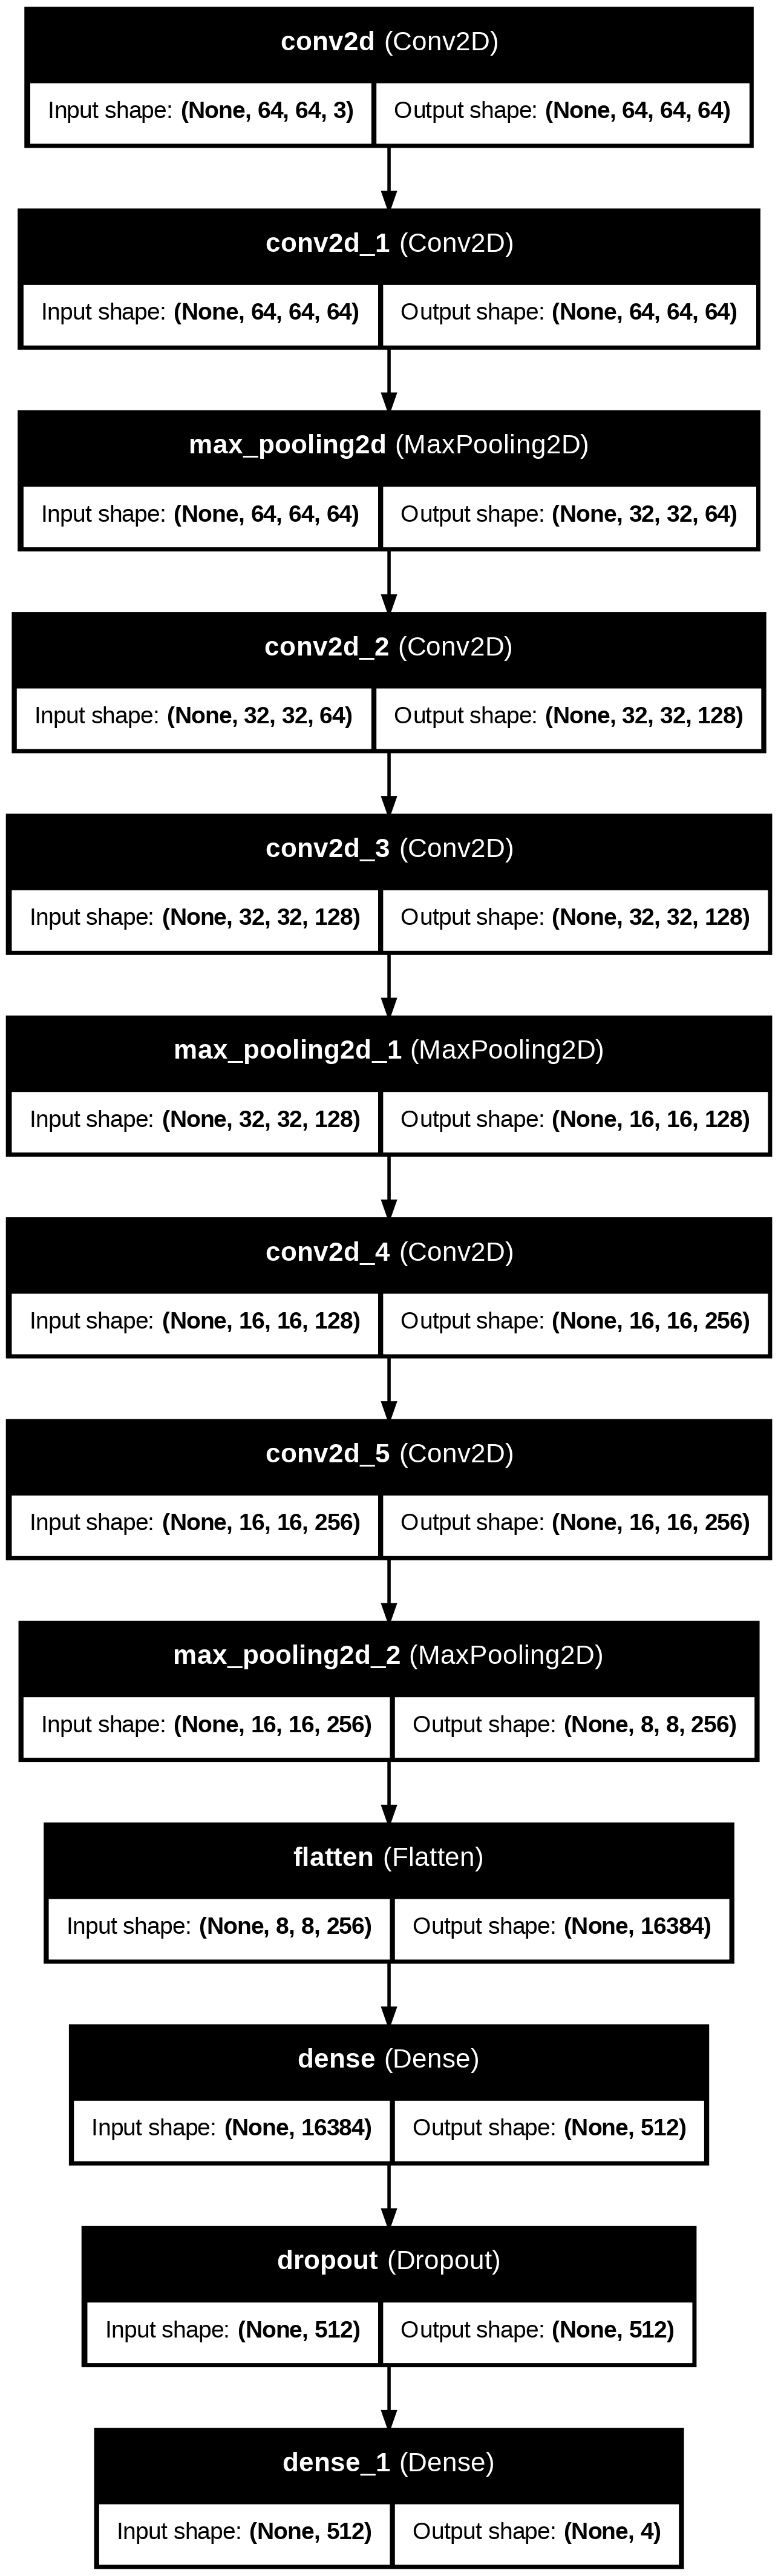

In [14]:
# A CNN model
# CNN Architecture
def create_cnn_model(input_shape):
    model = models.Sequential()
    # First block: Conv -> Conv -> MaxPool
    model.add(keras.Input(shape=input_shape))
    model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(layers.MaxPooling2D((2, 2)))

    # Second block: Conv -> Conv -> MaxPool
    model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(layers.MaxPooling2D((2, 2)))

    # Third block: Conv -> Conv -> MaxPool
    model.add(layers.Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(layers.Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(layers.MaxPooling2D((2, 2)))

    # Flatten and Dense layers
    model.add(layers.Flatten())
    model.add(layers.Dense(512, activation='relu'))
    model.add(layers.Dropout(0.5)) # Adding a dropout layer
    model.add(layers.Dense(len(class_names), activation='softmax'))  # Output layer with number of classes

    # Compile the model
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model


# CNN model
cnn_model = create_cnn_model((img_size, img_size, 3))
cnn_model.summary()

# Visualize the model
plot_model(cnn_model, to_file='cnn_model.png', show_shapes=True, show_layer_names=True)

### Model Training

In [15]:
# Train the CNN model (~1-2mins)
history_cnn = cnn_model.fit(image_train, label_train, epochs=100, batch_size=32, validation_split=0.2, callbacks=[early_stopping, reduce_lr])

Epoch 1/100
113/113 ━━━━━━━━━━━━━━━━━━━━ 17s 77ms/step - accuracy: 0.4844 - loss: 1.0031 - val_accuracy: 0.6615 - val_loss: 0.5561 - learning_rate: 0.0010
Epoch 2/100
113/113 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.6625 - loss: 0.5802 - val_accuracy: 0.6337 - val_loss: 0.5496 - learning_rate: 0.0010
Epoch 3/100
113/113 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.6734 - loss: 0.5638 - val_accuracy: 0.7947 - val_loss: 0.4315 - learning_rate: 0.0010
Epoch 4/100
113/113 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.7203 - loss: 0.5013 - val_accuracy: 0.7292 - val_loss: 0.4965 - learning_rate: 0.0010
Epoch 5/100
113/113 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.7529 - loss: 0.4933 - val_accuracy: 0.7037 - val_loss: 0.5235 - learning_rate: 0.0010
Epoch 6/100
113/113 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.7155 - loss: 0.5254 - val_accuracy: 0.6970 - val_loss: 0.4818 - learning_rate: 0.0010
Epoch 7/100
113/113 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.7089 - 

### Model Evaluation

In [16]:
# Predict labels for the test set
label_pred_cnn = cnn_model.predict(image_test).argmax(axis=1)

# Accuracy for CNN
cnn_acc = cnn_model.evaluate(image_test, label_test, verbose=0)[1]
print("CNN Accuracy:", cnn_acc)

36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step
CNN Accuracy: 0.9778172373771667


In [17]:
# Classification Report for CNN
print(classification_report(label_test, label_pred_cnn, target_names=class_names))

              precision    recall  f1-score   support

      cloudy       0.98      0.98      0.98       328
      desert       0.98      0.97      0.98       227
  green_area       0.97      0.99      0.98       284
       water       0.99      0.97      0.98       288

    accuracy                           0.98      1127
   macro avg       0.98      0.98      0.98      1127
weighted avg       0.98      0.98      0.98      1127



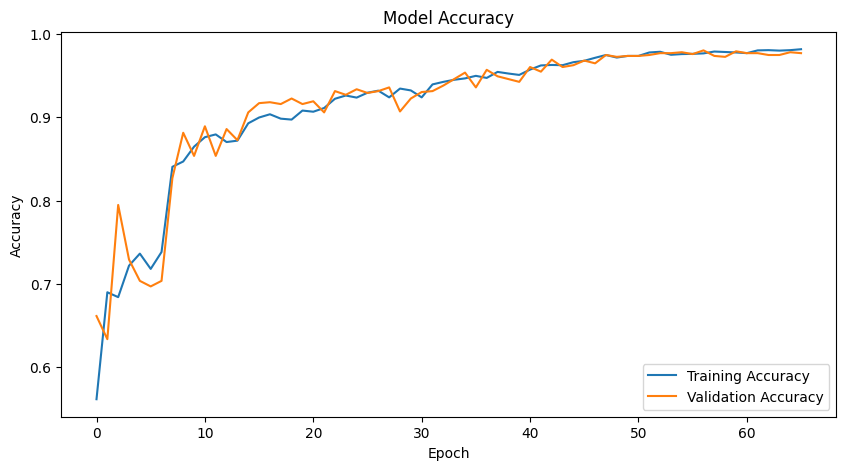

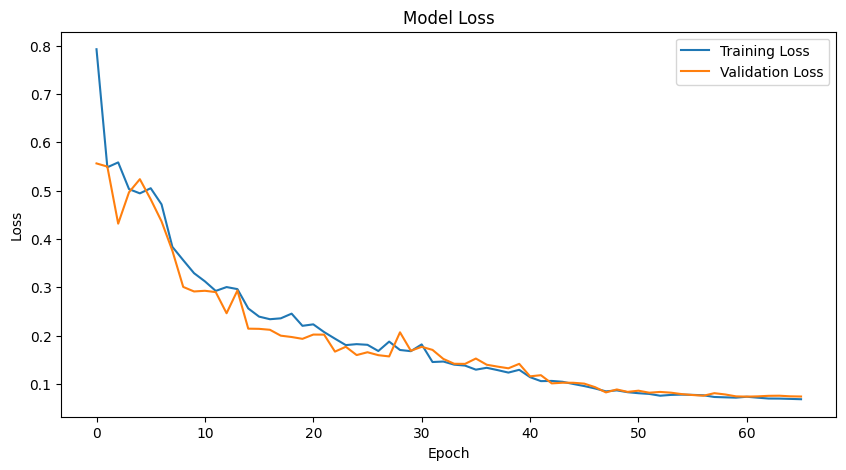

In [18]:
# Plot training history for CNN
plt.figure(figsize=(10, 5))
plt.plot(history_cnn.history['accuracy'], label='Training Accuracy')
plt.plot(history_cnn.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(history_cnn.history['loss'], label='Training Loss')
plt.plot(history_cnn.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.show()

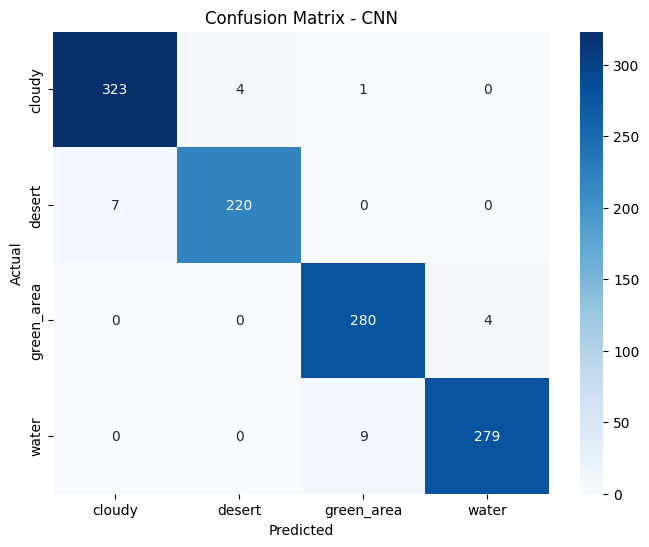

In [19]:
# Confusion Matrix for CNN
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(label_test, label_pred_cnn), annot=True, fmt="d", cmap = 'Blues', xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix - CNN")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


Calculating ROC for CNN: 100%|██████████| 4/4 [00:00<00:00, 287.03it/s]

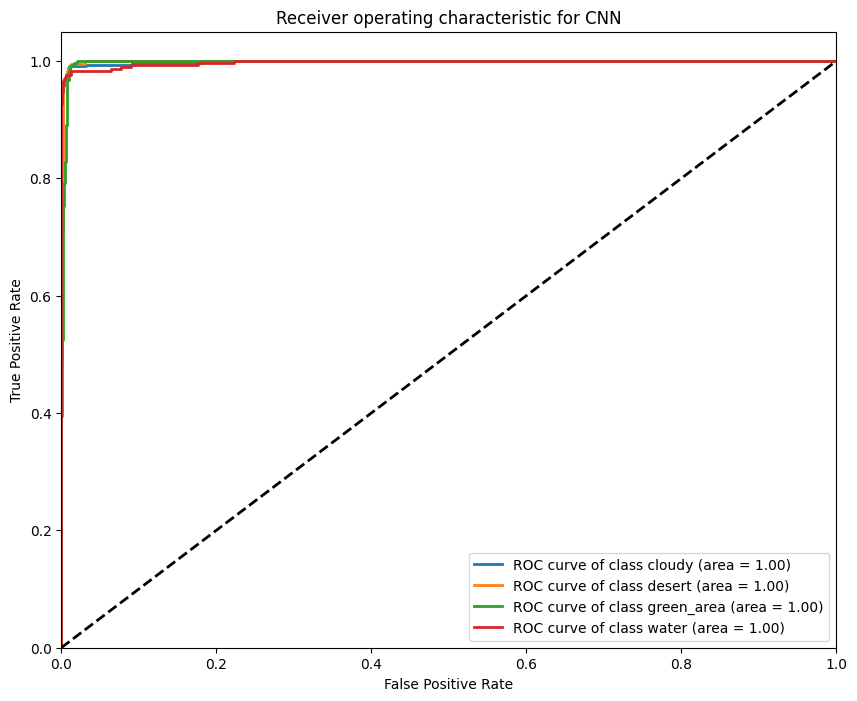

In [20]:
# AUROC Curve for CNN
cnn_proba = cnn_model.predict(image_test)

y_test_bin_cnn = label_binarize(label_test, classes=np.arange(len(class_names)))
n_classes = y_test_bin_cnn.shape[1]

plt.figure(figsize=(10, 8))
fpr_cnn = dict()
tpr_cnn = dict()
roc_auc_cnn = dict()

for i in tqdm(range(n_classes), desc="Calculating ROC for CNN"):
    fpr_cnn[i], tpr_cnn[i], _ = roc_curve(y_test_bin_cnn[:, i], cnn_proba[:, i])
    roc_auc_cnn[i] = auc(fpr_cnn[i], tpr_cnn[i])
    plt.plot(fpr_cnn[i], tpr_cnn[i], lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'.format(class_names[i], roc_auc_cnn[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for CNN')
plt.legend(loc="lower right")
print('\n')
plt.show()

In [21]:
# AUC for CNN
print("AUC for each class for CNN:")
for i in range(n_classes):
    print(f"Class {class_names[i]}: {roc_auc_cnn[i]:.4f}")

AUC for each class for CNN:
Class cloudy: 0.9987
Class desert: 0.9988
Class green_area: 0.9977
Class water: 0.9976


Calculating AUPR for CNN: 100%|██████████| 4/4 [00:00<00:00, 255.91it/s]


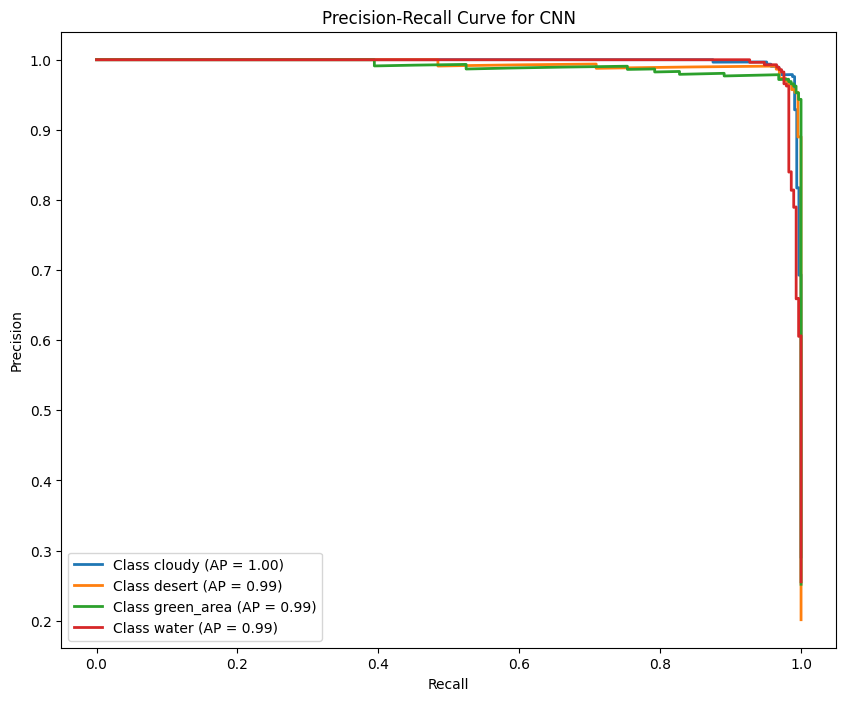

In [22]:
# AUPR Curve for CNN
plt.figure(figsize=(10, 8))
average_precision_cnn = dict()

for i in tqdm(range(n_classes), desc="Calculating AUPR for CNN"):
    precision, recall, _ = precision_recall_curve(y_test_bin_cnn[:, i], cnn_proba[:, i])
    average_precision_cnn[i] = average_precision_score(y_test_bin_cnn[:, i], cnn_proba[:, i])
    plt.plot(recall, precision, lw=2, label='Class {0} (AP = {1:0.2f})'.format(class_names[i], average_precision_cnn[i]))

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve for CNN")
plt.legend(loc="lower left")
print('\n')
plt.show()

In [23]:
# Average Precision for CNN
print("Average Precision for each class for CNN:")
for i in range(n_classes):
    print(f"Class {class_names[i]}: {average_precision_cnn[i]:.4f}")

Average Precision for each class for CNN:
Class cloudy: 0.9974
Class desert: 0.9942
Class green_area: 0.9913
Class water: 0.9949


In [24]:
# Top-K Accuracy for CNN
top1_acc_cnn = top_k_accuracy_score(label_test, cnn_proba, k=1)
top5_acc_cnn = top_k_accuracy_score(label_test, cnn_proba, k=min(5, n_classes))

print("Top-1 Accuracy for CNN:", top1_acc_cnn)
print(f"Top-{min(5, n_classes)} Accuracy for CNN:", top5_acc_cnn)

Top-1 Accuracy for CNN: 0.9778172138420586
Top-4 Accuracy for CNN: 1.0


## 2. VGG16 Model

### Building Model



58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 2, 2, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,977,476 (57.13 MB)

 Trainable params: 262,788 (1.00 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

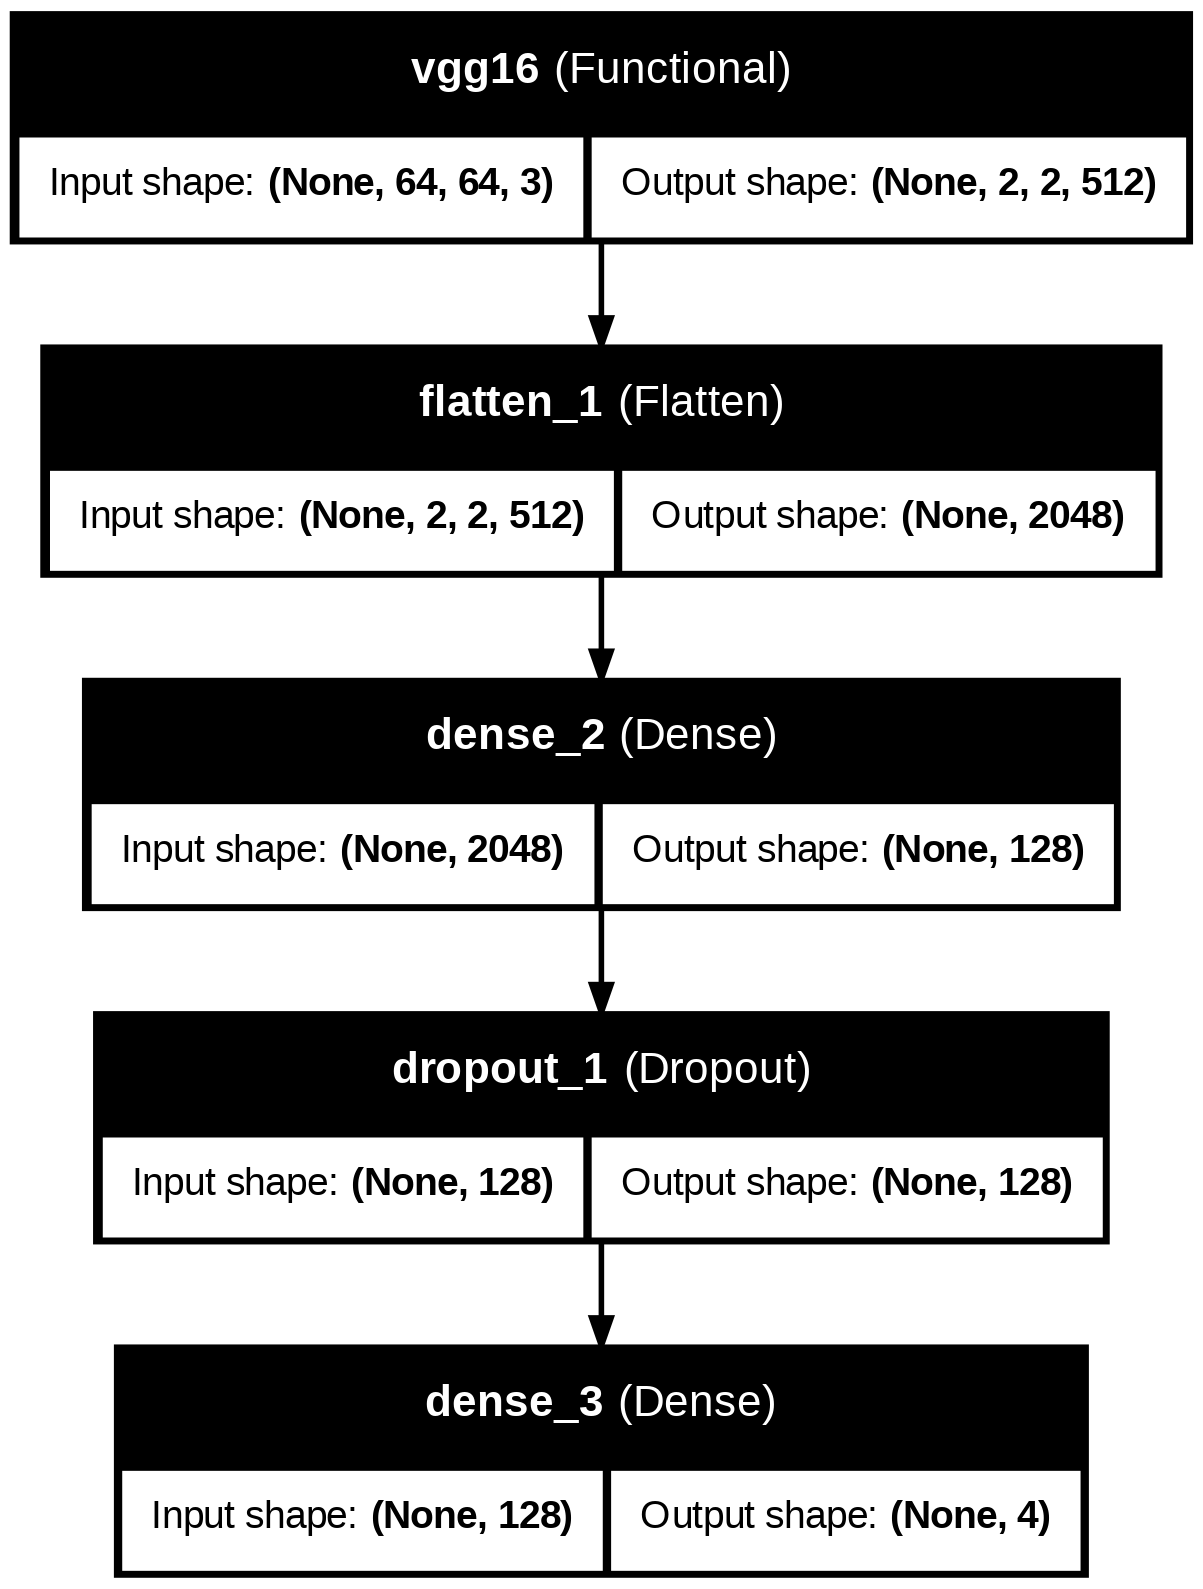

In [25]:
# Build a VGG16 model without the top layers
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(img_size, img_size, 3))

# Freeze the convolutional base
base_model.trainable = False

# Create a new model on top of the convolutional base
model_vgg = models.Sequential([
    base_model,
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(len(class_names), activation='softmax') # Output layer with number of classes
])

# Compile the model
model_vgg.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model_vgg.summary()
plot_model(model_vgg, to_file='vgg_model.png', show_shapes=True, show_layer_names=True)

### Model Training

In [26]:
# Model training (before fine-tune) (~0.5min)
history_vgg = model_vgg.fit(image_train, label_train,
                            epochs=100,
                            batch_size=32,
                            validation_split=0.2,
                            callbacks=[early_stopping, reduce_lr])

Epoch 1/100
113/113 ━━━━━━━━━━━━━━━━━━━━ 8s 46ms/step - accuracy: 0.5616 - loss: 1.0111 - val_accuracy: 0.8568 - val_loss: 0.3716 - learning_rate: 0.0010
Epoch 2/100
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.8697 - loss: 0.3920 - val_accuracy: 0.9312 - val_loss: 0.2264 - learning_rate: 0.0010
Epoch 3/100
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.8949 - loss: 0.3041 - val_accuracy: 0.9467 - val_loss: 0.1772 - learning_rate: 0.0010
Epoch 4/100
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9099 - loss: 0.2595 - val_accuracy: 0.9301 - val_loss: 0.1609 - learning_rate: 0.0010
Epoch 5/100
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9242 - loss: 0.2173 - val_accuracy: 0.9523 - val_loss: 0.1276 - learning_rate: 0.0010
Epoch 6/100
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9356 - loss: 0.1873 - val_accuracy: 0.9512 - val_loss: 0.1344 - learning_rate: 0.0010
Epoch 7/100
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9284 - loss

### Model Evaluation

In [27]:
label_pred_vgg = model_vgg.predict(image_test).argmax(axis=1)  # Get predicted labels

# Accuracy for VGG16 (Pre-finetune)
vgg_acc = model_vgg.evaluate(image_test, label_test, verbose=0)[1]
print("VGG16 Accuracy:", vgg_acc)

36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step
VGG16 Accuracy: 0.9662821888923645


In [28]:
# Classification Report for VGG16 (Pre-finetune)
print(classification_report(label_test, label_pred_vgg, target_names=class_names))

              precision    recall  f1-score   support

      cloudy       0.98      0.96      0.97       328
      desert       0.96      0.99      0.97       227
  green_area       0.96      0.97      0.97       284
       water       0.95      0.95      0.95       288

    accuracy                           0.97      1127
   macro avg       0.97      0.97      0.97      1127
weighted avg       0.97      0.97      0.97      1127



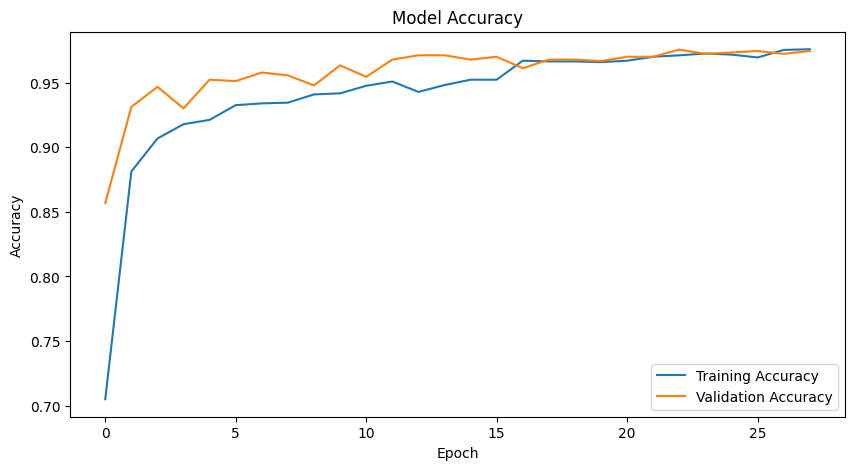

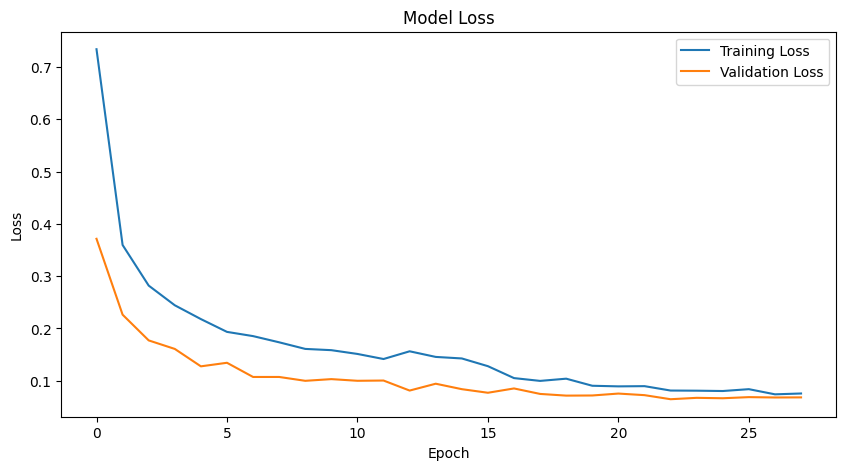

In [29]:
# Plot training history for VGG16 (Pre-finetune)
plt.figure(figsize=(10, 5))
plt.plot(history_vgg.history['accuracy'], label='Training Accuracy')
plt.plot(history_vgg.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(history_vgg.history['loss'], label='Training Loss')
plt.plot(history_vgg.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.show()

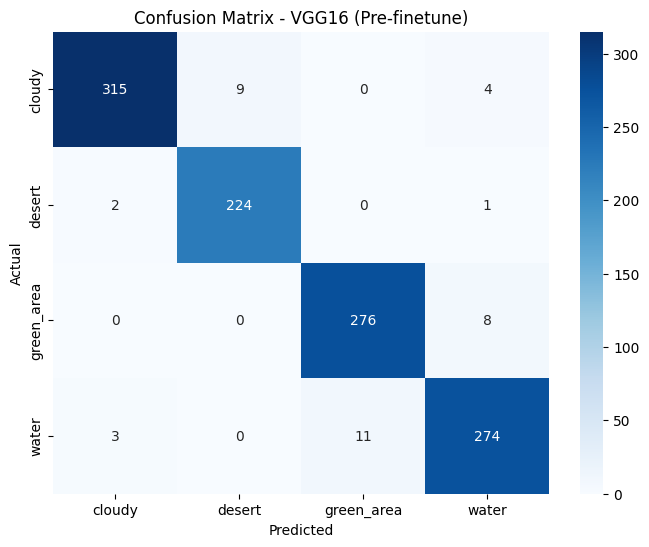

In [30]:
# Confusion Matrix for VGG16 (Pre-finetune)
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(label_test, label_pred_vgg), annot=True, fmt="d", cmap = 'Blues', xticklabels=class_names, yticklabels=class_names) # Use y_test for evaluation
plt.title("Confusion Matrix - VGG16 (Pre-finetune)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

### Hyperparameter Tuning with RandomSearchCV:

To improve performance, the VGG16 model was fine-tuned, training some of its initial layers on the satellite images. KerasTuner's RandomSearch was used to find the best settings for this fine-tuning, such as how many layers to train and the best dense layer and dropout values. A smaller part of the training data was used for this search. The best settings were found based on how well the model performed on a validation set. Finally, a new model was built using these best settings and the pre-trained VGG16 weights.

In [31]:
def build_vgg_finetune_model_for_tuner(hp):
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=(img_size, img_size, 3))
    # Determine the number of layers to unfreeze based on hyperparameter tuning
    # You can tune the number of layers to unfreeze
    # Use the total number of layers in the base model as the maximum
    max_unfreeze_layers = len(base_model.layers)
    unfreeze_layers_to_tune = hp.Int('unfreeze_layers', min_value=1, max_value=max_unfreeze_layers, step=1)
    unfreeze_from_layer = len(base_model.layers) - unfreeze_layers_to_tune

    # Freeze all base model layers initially
    base_model.trainable = False
    for layer in base_model.layers:
        layer.trainable = False

    # Unfreeze the specified number of layers from the end of the base model
    for layer in base_model.layers[unfreeze_from_layer:]:
        layer.trainable = True

    # Create a new model on top of the convolutional base
    model = models.Sequential([
        base_model,
        layers.Flatten(),
        layers.Dense(hp.Choice('dense_units', values=[128, 256, 512]), activation='relu'),
        layers.Dropout(hp.Float('dropout_rate', min_value=0.2, max_value=0.5, step=0.1)),
        layers.Dense(len(class_names), activation='softmax')
    ])

    # Compile the model with tunable optimizer and learning rate
    optimizer_choice = hp.Choice('optimizer', values=['adam', 'rmsprop', 'adamax'])
    if optimizer_choice == 'adam':
        optimizer = tf.keras.optimizers.Adam(hp.Float('learning_rate_adam', min_value=1e-6, max_value=1e-4, sampling='LOG'))
    elif optimizer_choice == 'rmsprop':
        optimizer = tf.keras.optimizers.RMSprop(hp.Float('learning_rate_rmsprop', min_value=1e-6, max_value=1e-4, sampling='LOG'))
    else: # adamax
        optimizer = tf.keras.optimizers.Adamax(hp.Float('learning_rate_adamax', min_value=1e-6, max_value=1e-4, sampling='LOG'))


    model.compile(optimizer=optimizer,
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

In [32]:
# Instantiate the tuner for VGG16 fine-tuning
# Using a different project name to keep results separate
tuner_vgg_finetune = RandomSearch(
    build_vgg_finetune_model_for_tuner,
    objective='val_accuracy',
    max_trials=10,  # Set the fixed number of trials here
    executions_per_trial=1, # Recommended to set to 1 for faster tuning
    directory='keras_tuner_vgg_finetune_dir',
    project_name='vgg_finetune_tuning_random' # Use a different project name
)

In [33]:
# This uses the original image data (image_train) not the flattened data
with tqdm(total=1, desc="Subsampling data for KerasTuner (DL)") as pbar:
    image_train_tune, _, label_train_tune, _ = train_test_split(
        image_train, label_train, test_size=0.8, random_state=42
    )
    pbar.update(1)

print(f"\n\nNumber of images in the tuning subsample (DL): {image_train_tune.shape[0]}\n")

Subsampling data for KerasTuner (DL): 100%|██████████| 1/1 [00:00<00:00,  7.78it/s]



Number of images in the tuning subsample (DL): 900



In [34]:
# Run the random search for VGG16 fine-tuning (~3-5mins)
# Use the same subsampled training data
print("Running KerasTuner search for VGG16 fine-tuning...")
tuner_vgg_finetune.search(image_train_tune, label_train_tune,
                          validation_split=0.2,
                          epochs=25, # Initial epochs for exploration
                          callbacks=[early_stopping, reduce_lr])

Trial 10 Complete [00h 00m 17s]
val_accuracy: 0.9833333492279053

Best val_accuracy So Far: 0.9888888597488403
Total elapsed time: 00h 04m 27s


In [35]:
# Get the best hyperparameters for VGG16 fine-tuning
best_hps_vgg_finetune = tuner_vgg_finetune.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The optimal number of layers to unfreeze in the base model is {best_hps_vgg_finetune.get('unfreeze_layers')}.
The optimal number of dense units is {best_hps_vgg_finetune.get('dense_units')}.
The optimal dropout rate is {best_hps_vgg_finetune.get('dropout_rate')}.
The optimal optimizer is {best_hps_vgg_finetune.get('optimizer')}.
""")
if best_hps_vgg_finetune.get('optimizer') == 'adam':
     print(f"The optimal learning rate is {best_hps_vgg_finetune.get('learning_rate_adam')}.")
elif best_hps_vgg_finetune.get('optimizer') == 'rmsprop':
     print(f"The optimal learning rate is {best_hps_vgg_finetune.get('learning_rate_rmsprop')}.")
else: # adamax
     print(f"The optimal learning rate is {best_hps_vgg_finetune.get('learning_rate_adamax')}.")


The optimal number of layers to unfreeze in the base model is 14.
The optimal number of dense units is 512.
The optimal dropout rate is 0.2.
The optimal optimizer is rmsprop.

The optimal learning rate is 4.706250120495539e-05.


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 2, 2, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     1,049,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │         2,052 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,765,828 (60.14 MB)

 Trainable params: 15,653,252 (59.71 MB)

 Non-trainable params: 112,576 (439.75 KB)

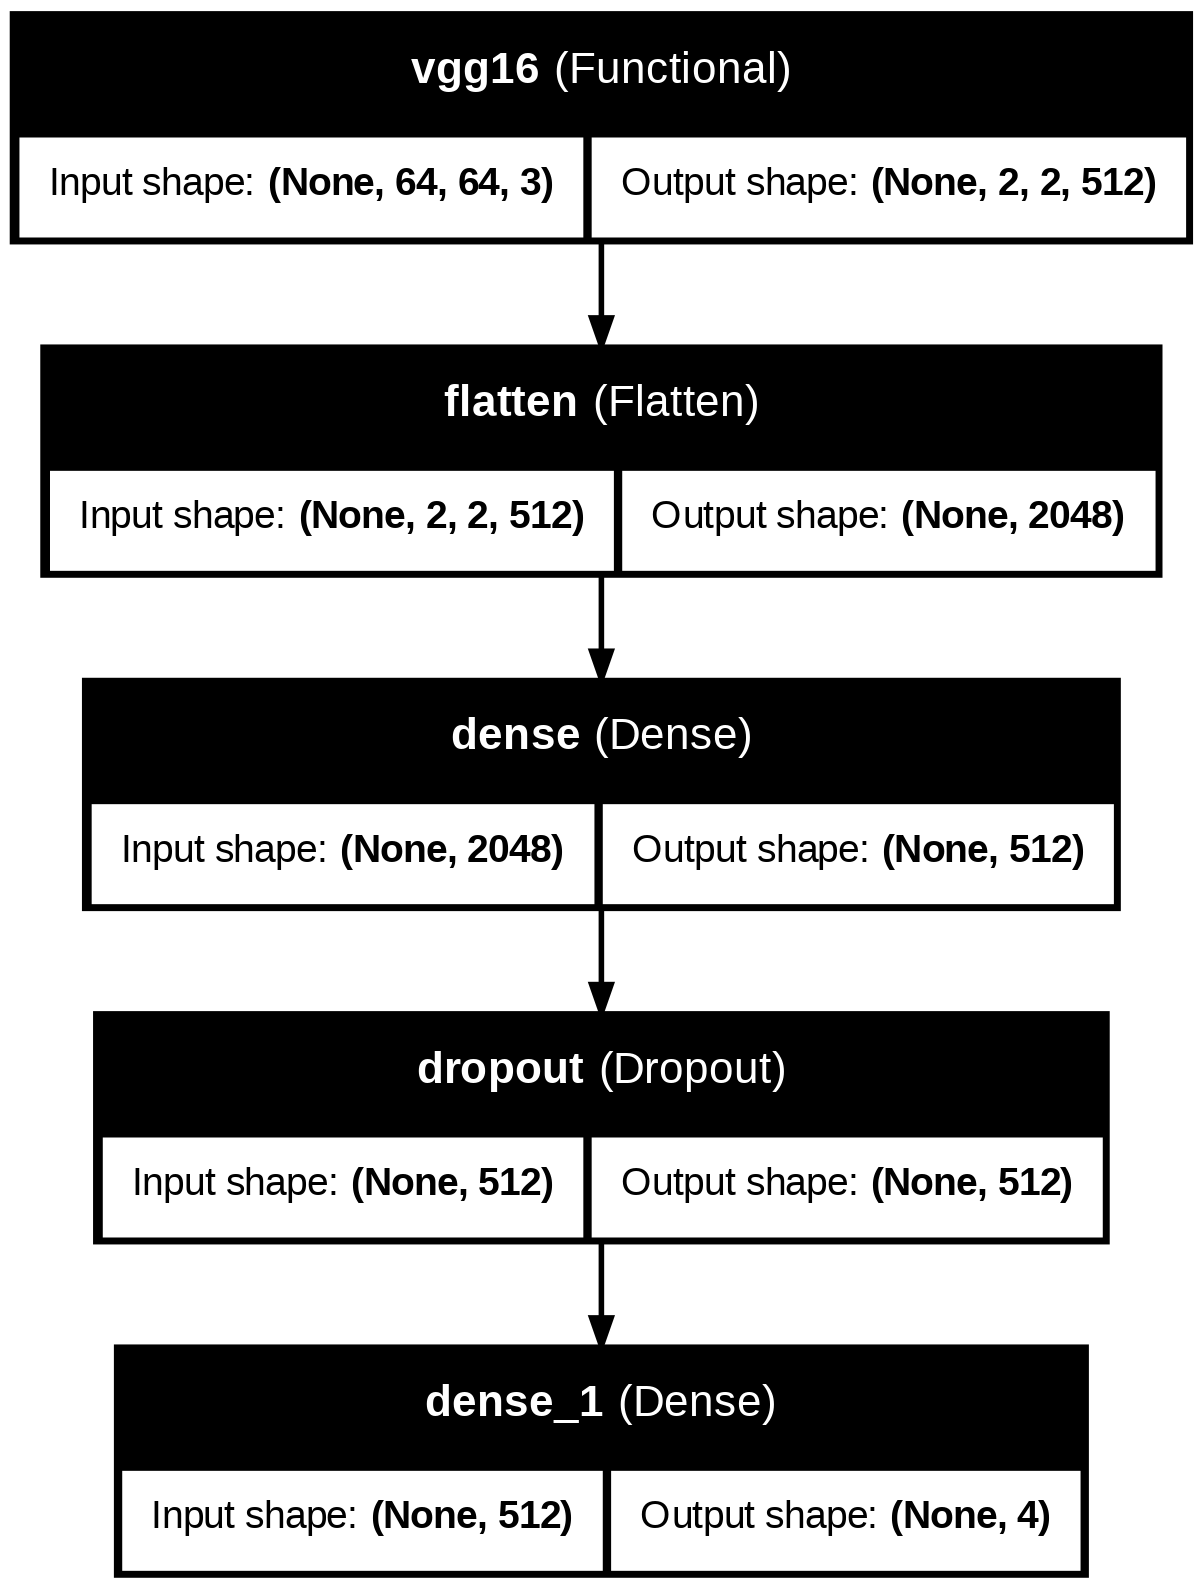

In [36]:
# Build the best VGG16 fine-tuned model
best_vgg_finetune_model = tuner_vgg_finetune.get_best_models(num_models=1)[0]
best_vgg_finetune_model.summary()
plot_model(best_vgg_finetune_model, to_file='best_vgg_finetune_model.png', show_shapes=True, show_layer_names=True)

### Best Model Training

In [37]:
# Train the best VGG16 fine-tuned model on the full training data (~1min)
print("Training the best VGG16 fine-tuned model on the full training data...")
history_vgg_finetune = best_vgg_finetune_model.fit(image_train, label_train,
                                                       epochs=100, # Train for more epochs now on the full dataset
                                                       batch_size=32,
                                                       validation_split=0.2,
                                                       callbacks=[early_stopping, reduce_lr])

Training the best VGG16 fine-tuned model on the full training data...
Epoch 1/100
113/113 ━━━━━━━━━━━━━━━━━━━━ 10s 53ms/step - accuracy: 0.8766 - loss: 0.4995 - val_accuracy: 0.9656 - val_loss: 0.0848 - learning_rate: 4.7063e-05
Epoch 2/100
113/113 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.9321 - loss: 0.2089 - val_accuracy: 0.8302 - val_loss: 0.4192 - learning_rate: 4.7063e-05
Epoch 3/100
113/113 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.9301 - loss: 0.1722 - val_accuracy: 0.9845 - val_loss: 0.0601 - learning_rate: 4.7063e-05
Epoch 4/100
113/113 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.9450 - loss: 0.1342 - val_accuracy: 0.9667 - val_loss: 0.0963 - learning_rate: 4.7063e-05
Epoch 5/100
113/113 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.9584 - loss: 0.1275 - val_accuracy: 0.9667 - val_loss: 0.0811 - learning_rate: 4.7063e-05
Epoch 6/100
113/113 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.9610 - loss: 0.1234 - val_accuracy: 0.9789 - val_loss: 0.0434 - learnin

### Best Model Evaluation

In [38]:
# Evaluate the best VGG16 fine-tuned model
print("Evaluating the best VGG16 fine-tuned model...")
label_pred_vgg_finetune = best_vgg_finetune_model.predict(image_test).argmax(axis=1)
vgg_finetune_acc = best_vgg_finetune_model.evaluate(image_test, label_test, verbose=0)[1]
print("Tuned VGG16 (Post-finetune) Accuracy:", vgg_finetune_acc)

Evaluating the best VGG16 fine-tuned model...
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step
Tuned VGG16 (Post-finetune) Accuracy: 0.9937888383865356


In [39]:
# Classification Report for VGG16 (Post-finetuned)
print(classification_report(label_test, label_pred_vgg_finetune, target_names=class_names))

              precision    recall  f1-score   support

      cloudy       1.00      1.00      1.00       328
      desert       1.00      1.00      1.00       227
  green_area       0.98      1.00      0.99       284
       water       1.00      0.98      0.99       288

    accuracy                           0.99      1127
   macro avg       0.99      0.99      0.99      1127
weighted avg       0.99      0.99      0.99      1127



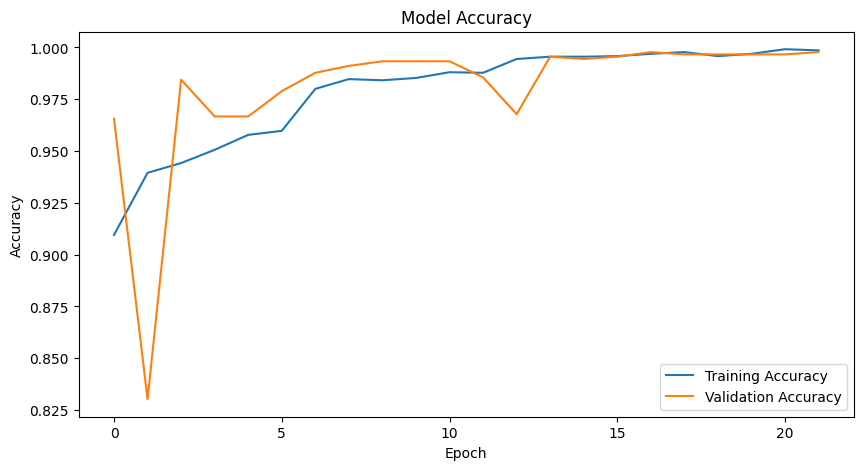

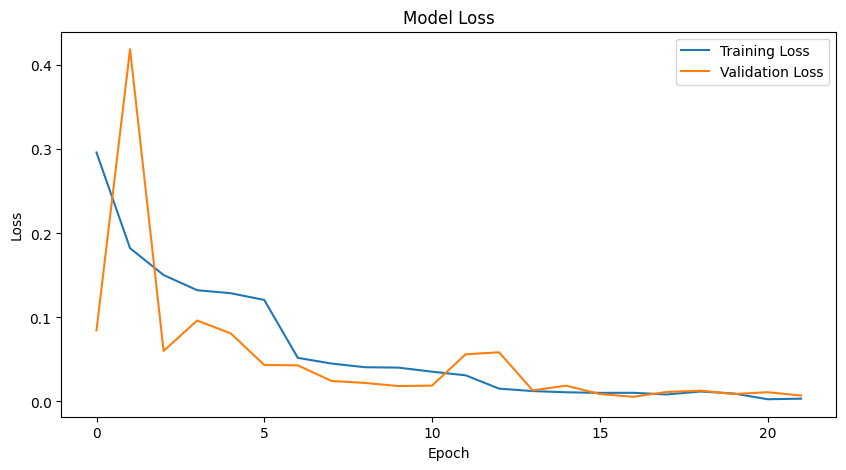

In [40]:
# Plot training history for VGG16 (Post-finetuned)
plt.figure(figsize=(10, 5))
plt.plot(history_vgg_finetune.history['accuracy'], label='Training Accuracy')
plt.plot(history_vgg_finetune.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(history_vgg_finetune.history['loss'], label='Training Loss')
plt.plot(history_vgg_finetune.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.show()

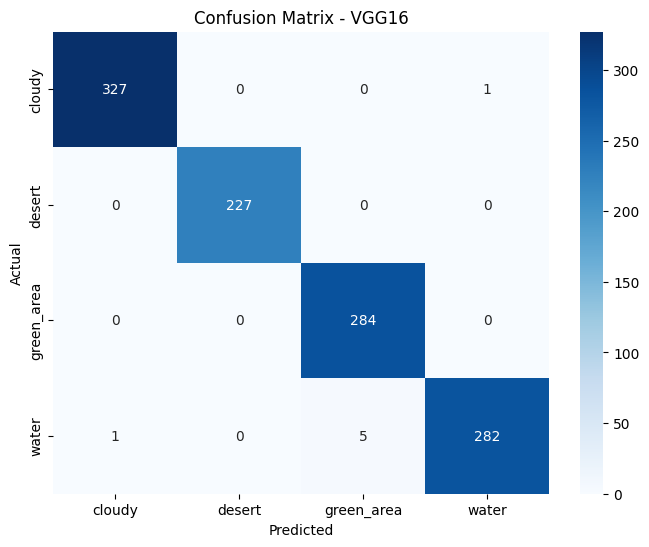

In [41]:
# Confusion Matrix for VGG16 (Post-finetuned)
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(label_test, label_pred_vgg_finetune), annot=True, fmt="d", cmap = 'Blues', xticklabels=class_names, yticklabels=class_names) # Use y_test for evaluation
plt.title("Confusion Matrix - VGG16")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


Calculating ROC for VGG16 (Post-finetuned): 100%|██████████| 4/4 [00:00<00:00, 298.53it/s]

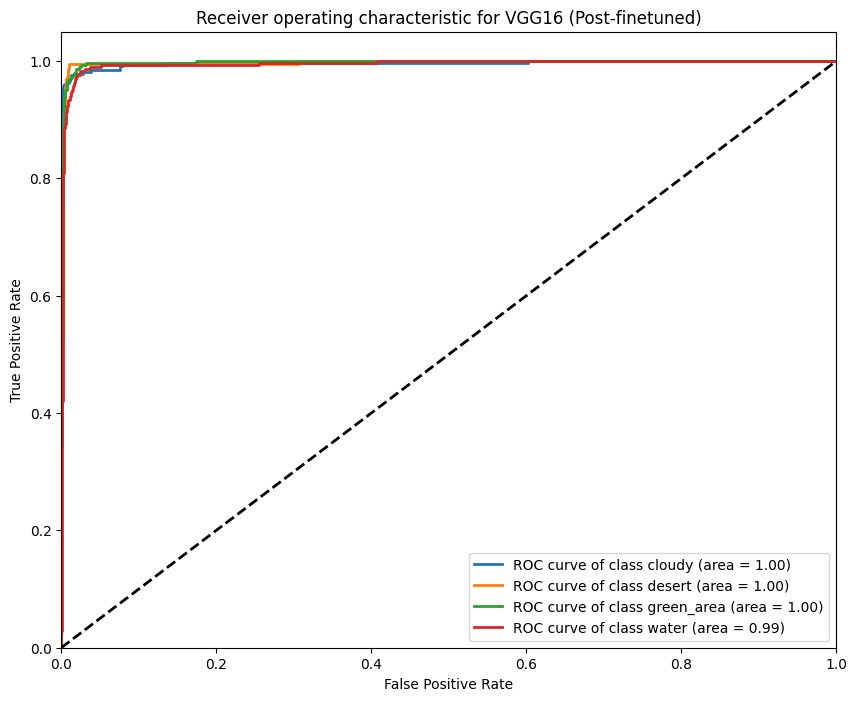

In [42]:
# AUROC Curve for VGG16 (Post-finetuned)
vgg_proba = model_vgg.predict(image_test)

y_test_bin_vgg = label_binarize(label_test, classes=np.arange(len(class_names)))
n_classes = y_test_bin_vgg.shape[1]

plt.figure(figsize=(10, 8))
fpr_vgg = dict()
tpr_vgg = dict()
roc_auc_vgg = dict()

for i in tqdm(range(n_classes), desc="Calculating ROC for VGG16 (Post-finetuned)"):
    fpr_vgg[i], tpr_vgg[i], _ = roc_curve(y_test_bin_vgg[:, i], vgg_proba[:, i])
    roc_auc_vgg[i] = auc(fpr_vgg[i], tpr_vgg[i])
    plt.plot(fpr_vgg[i], tpr_vgg[i], lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'.format(class_names[i], roc_auc_vgg[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for VGG16 (Post-finetuned)')
plt.legend(loc="lower right")
print('\n')
plt.show()

In [43]:
# AUC for VGG16 (Post-finetuned)
print("AUC for each class (VGG16 Post-finetuned):")
for i in range(n_classes):
    print(f"Class {class_names[i]}: {roc_auc_vgg[i]:.4f}")

AUC for each class (VGG16 Post-finetuned):
Class cloudy: 0.9965
Class desert: 0.9977
Class green_area: 0.9974
Class water: 0.9945


Calculating AUPR for VGG16 (Post-finetuned): 100%|██████████| 4/4 [00:00<00:00, 217.05it/s]


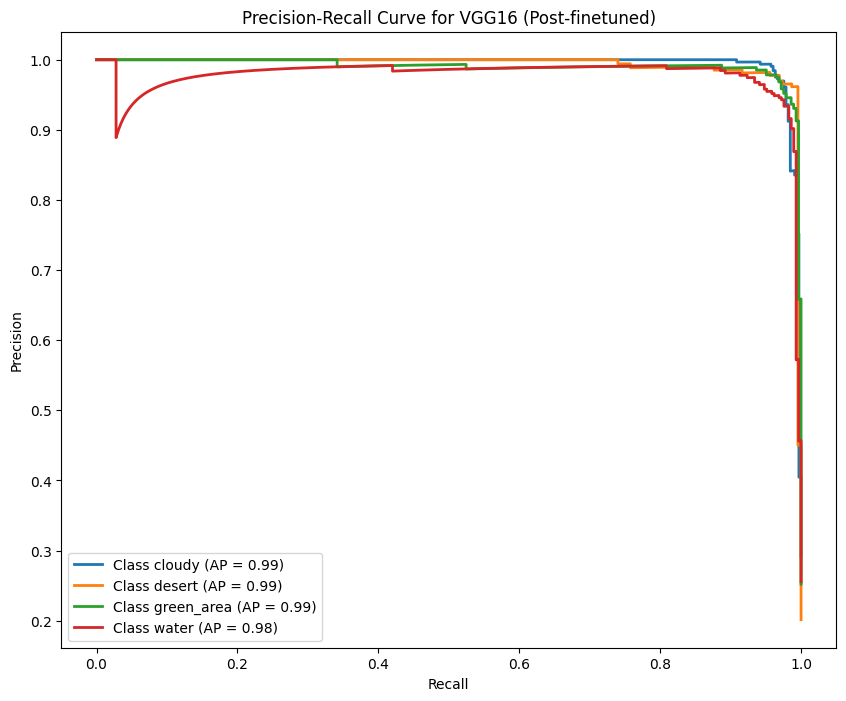

In [44]:
# AUPR Curve for VGG16 (Post-finetuned)
plt.figure(figsize=(10, 8))
average_precision_vgg = dict()

for i in tqdm(range(n_classes), desc="Calculating AUPR for VGG16 (Post-finetuned)"):
    precision, recall, _ = precision_recall_curve(y_test_bin_vgg[:, i], vgg_proba[:, i])
    average_precision_vgg[i] = average_precision_score(y_test_bin_vgg[:, i], vgg_proba[:, i])
    plt.plot(recall, precision, lw=2, label='Class {0} (AP = {1:0.2f})'.format(class_names[i], average_precision_vgg[i]))

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve for VGG16 (Post-finetuned)")
plt.legend(loc="lower left")
print('\n')
plt.show()

In [45]:
# Average Precision for VGG16 (Post-finetuned)
print("Average Precision for each class for VGG16 (Post-finetuned):")
for i in range(n_classes):
    print(f"Class {class_names[i]}: {average_precision_vgg[i]:.4f}")


Average Precision for each class for VGG16 (Post-finetuned):
Class cloudy: 0.9948
Class desert: 0.9937
Class green_area: 0.9909
Class water: 0.9780


In [46]:
# Top-K Accuracy for VGG16 (Post-finetuned)
top1_acc_vgg = top_k_accuracy_score(label_test, vgg_proba, k=1)
top5_acc_vgg = top_k_accuracy_score(label_test, vgg_proba, k=min(5, n_classes))

print("Top-1 Accuracy for VGG16 (Post-finetuned):", top1_acc_vgg)
print(f"Top-{min(5, n_classes)} Accuracy for VGG16 (Post-finetuned):", top5_acc_vgg)

Top-1 Accuracy for VGG16 (Post-finetuned): 0.966282165039929
Top-4 Accuracy for VGG16 (Post-finetuned): 1.0


# Machine Learning Models

## 1.   KMeans + PCA (Unsupervised)

### Model Training

In [47]:
# Unsupervised KMeans with PCA
with tqdm(total=2, desc="KMeans + PCA training") as pbar:
    pca = PCA(n_components=50)
    X_pca = pca.fit_transform(image_data_flat)
    pbar.update(1)

    kmeans_pca = KMeans(n_clusters=4, random_state=42)  # Adjusted for 4 classes
    clusters_pca = kmeans_pca.fit_predict(X_pca)
    pbar.update(1)

def infer_labels(true, pred):
    label_map = {}
    for i in range(4):  # Adjusted for 4 classes
        mask = pred == i
        target = true[mask]
        if len(target) > 0:
            label_map[i] = np.bincount(target).argmax()
    return np.vectorize(label_map.get)(pred)


KMeans + PCA training: 100%|██████████| 2/2 [00:05<00:00,  2.84s/it]


### Model Evaluation

Since KMeans is unsupervised, evaluation was conducted by inferring labels for the clusters. This was done by determining the most frequent true class within each cluster and assigning it as the cluster's label. Performance was then measured using accuracy, a classification report, and a confusion matrix for visualization. Standard metrics such as AUROC and AUPR are not applicable.

In [48]:
# Accuracy for KMeans + PCA
pred_label_pca = infer_labels(label, clusters_pca)
kmeans_pca_acc = accuracy_score(label, pred_label_pca)
print("KMeans + PCA accuracy:", kmeans_pca_acc)

KMeans + PCA accuracy: 0.5911916178298704


In [49]:
# Classification Report for KMeans + PCA
print(classification_report(label, pred_label_pca, target_names=class_names, zero_division=1))

              precision    recall  f1-score   support

      cloudy       0.65      0.46      0.54      1500
      desert       0.52      0.68      0.59      1131
  green_area       0.57      0.99      0.73      1500
       water       0.78      0.26      0.39      1500

    accuracy                           0.59      5631
   macro avg       0.63      0.60      0.56      5631
weighted avg       0.64      0.59      0.56      5631



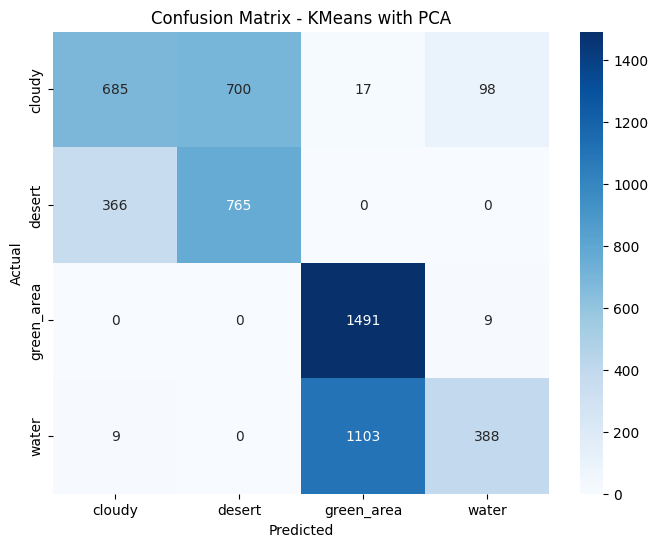

In [50]:
# Confusion Matrix for KMeans + PCA
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(label, pred_label_pca), annot=True, fmt="d", cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix - KMeans with PCA")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

## 2. SVM (Supervised)




### Model training

In [51]:
# Supervised SVM (~5mins)
with tqdm(total=1, desc="SVM Training") as pbar:
    svm_model = SVC(kernel='rbf', C=100, gamma='auto', probability=True)
    svm_model.fit(image_train_svm, label_train_svm)
    pbar.update(1)

label_pred_svm = svm_model.predict(image_test_svm)
label_proba_svm = svm_model.predict_proba(image_test_svm)

SVM Training: 100%|██████████| 1/1 [02:50<00:00, 170.16s/it]


### Model Evaluation

In [52]:
# Accuracy for SVM (Before GridSearchCV)
svm_acc_before = accuracy_score(label_test_svm, label_pred_svm)  # Store before GridSearchCV
print("SVM Accuracy (Before GridSearchCV):", svm_acc_before)

SVM Accuracy (Before GridSearchCV): 0.9103815439219166


In [53]:
# Classification Report for SVM (Before GridSearchCV)
print(classification_report(label_test_svm, label_pred_svm, target_names=class_names))

              precision    recall  f1-score   support

      cloudy       0.96      0.94      0.95       328
      desert       0.93      0.95      0.94       227
  green_area       0.83      0.94      0.88       284
       water       0.93      0.82      0.87       288

    accuracy                           0.91      1127
   macro avg       0.91      0.91      0.91      1127
weighted avg       0.91      0.91      0.91      1127



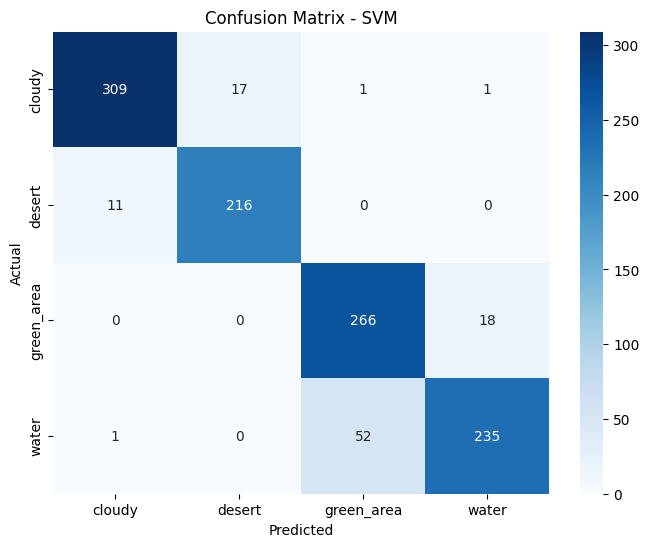

In [54]:
# Confusion Matrix for SVM (Before GridSearchCV)
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(label_test_svm, label_pred_svm), annot=True, fmt="d", cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix - SVM")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()
pbar.update(1)

### Hyperparameter Tuning with GridSearchCV:



In [55]:
#To optimize the SVM model, hyperparameter tuning was done using GridSearchCV on a subsample of the training data.
#It explored a grid of C and gamma values for the RBF kernel using cross-validation.

# Subsampling data for GridSearchCV
with tqdm(total=1, desc="Subsampling data for GridSearchCV") as pbar:
    image_train_tune, _, label_train_tune, _ = train_test_split(
        image_train_svm, label_train_svm, test_size=0.8, random_state=42
    )
    pbar.update(1)  # Update the progress bar after the split

print(f"\n\nNumber of images in the tuning subsample: {image_train_tune.shape[0]}\n")

Subsampling data for GridSearchCV: 100%|██████████| 1/1 [00:00<00:00,  7.79it/s]



Number of images in the tuning subsample: 900



In [56]:
## ~20mins

# Define the parameter distributions
param_grid = {
       'C': [0.1, 1, 10, 100],
       'gamma': ['scale', 'auto', 0.01, 0.1],
       'kernel': ['rbf']
   }

# Create a GridSearchCV object
grid_search = GridSearchCV(
    SVC(probability=True),
    param_grid=param_grid,
    n_jobs=1,
    refit=True,
    verbose=3,
)

# Fit the grid search to the data
grid_search.fit(image_train_tune, label_train_tune)

Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV 1/5] END ....C=0.1, gamma=scale, kernel=rbf;, score=0.778 total time=  14.7s
[CV 2/5] END ....C=0.1, gamma=scale, kernel=rbf;, score=0.700 total time=  14.2s
[CV 3/5] END ....C=0.1, gamma=scale, kernel=rbf;, score=0.694 total time=  14.0s
[CV 4/5] END ....C=0.1, gamma=scale, kernel=rbf;, score=0.689 total time=  17.5s
[CV 5/5] END ....C=0.1, gamma=scale, kernel=rbf;, score=0.739 total time=  13.9s
[CV 1/5] END .....C=0.1, gamma=auto, kernel=rbf;, score=0.522 total time=  23.8s
[CV 2/5] END .....C=0.1, gamma=auto, kernel=rbf;, score=0.528 total time=  23.5s
[CV 3/5] END .....C=0.1, gamma=auto, kernel=rbf;, score=0.522 total time=  21.2s
[CV 4/5] END .....C=0.1, gamma=auto, kernel=rbf;, score=0.517 total time=  23.6s
[CV 5/5] END .....C=0.1, gamma=auto, kernel=rbf;, score=0.522 total time=  20.6s
[CV 1/5] END .....C=0.1, gamma=0.01, kernel=rbf;, score=0.867 total time=  14.0s
[CV 2/5] END .....C=0.1, gamma=0.01, kernel=rbf;

GridSearchCV(estimator=SVC(probability=True), n_jobs=1,
             param_grid={'C': [0.1, 1, 10, 100],
                         'gamma': ['scale', 'auto', 0.01, 0.1],
                         'kernel': ['rbf']},
             verbose=3)

In [57]:
# Print the best parameters and best score
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best cross-validation score: {grid_search.best_score_}")

# Find and print the worst parameters
# grid_search.cv_results_ is a dictionary containing all the results
results = grid_search.cv_results_
mean_scores = results['mean_test_score']
params = results['params']

# Find the index of the minimum mean score
worst_index = np.argmin(mean_scores)

# Get the parameters corresponding to the worst index
worst_params = params[worst_index]
worst_score = mean_scores[worst_index]

print(f"\nWorst parameters: {worst_params}")
print(f"Worst cross-validation score: {worst_score}")

Best parameters: {'C': 10, 'gamma': 0.01, 'kernel': 'rbf'}
Best cross-validation score: 0.928888888888889

Worst parameters: {'C': 0.1, 'gamma': 'auto', 'kernel': 'rbf'}
Worst cross-validation score: 0.5222222222222223


### Best SVM Model Evaluation

In [58]:
# Use the best estimator for predictions
best_svm_model = grid_search.best_estimator_
label_pred_svm = best_svm_model.predict(image_test_svm)
label_proba_svm = best_svm_model.predict_proba(image_test_svm)

# Accuracy for SVM (After GridSearchCV)
svm_acc = accuracy_score(label_test_svm, label_pred_svm)
print("SVM Accuracy (best model):", svm_acc)

SVM Accuracy (best model): 0.927240461401952


In [59]:
# Classification Report for SVM (After GridSearchCV)
print(classification_report(label_test_svm, label_pred_svm, target_names=class_names))

              precision    recall  f1-score   support

      cloudy       0.95      0.96      0.95       328
      desert       0.96      0.93      0.95       227
  green_area       0.86      0.96      0.91       284
       water       0.95      0.85      0.90       288

    accuracy                           0.93      1127
   macro avg       0.93      0.93      0.93      1127
weighted avg       0.93      0.93      0.93      1127



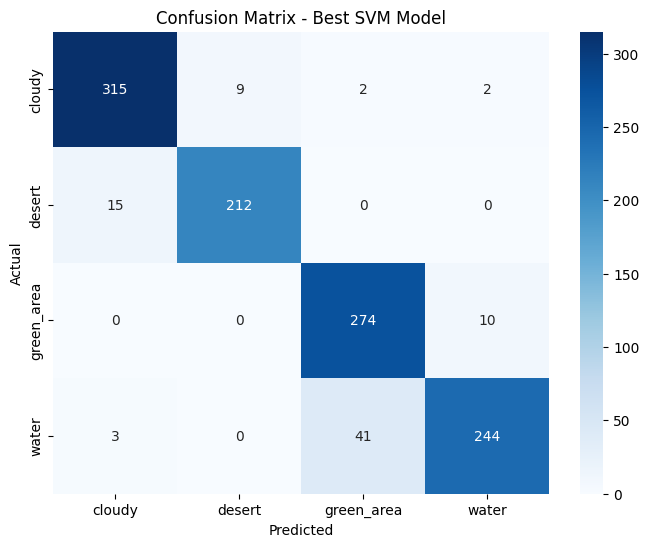

In [60]:
# Confusion Matrix for SVM (After GridSearchCV)
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(label_test_svm, label_pred_svm), annot=True, fmt="d", cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix - Best SVM Model")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

Calculating ROC for Best SVM: 100%|██████████| 4/4 [00:00<00:00, 236.24it/s]

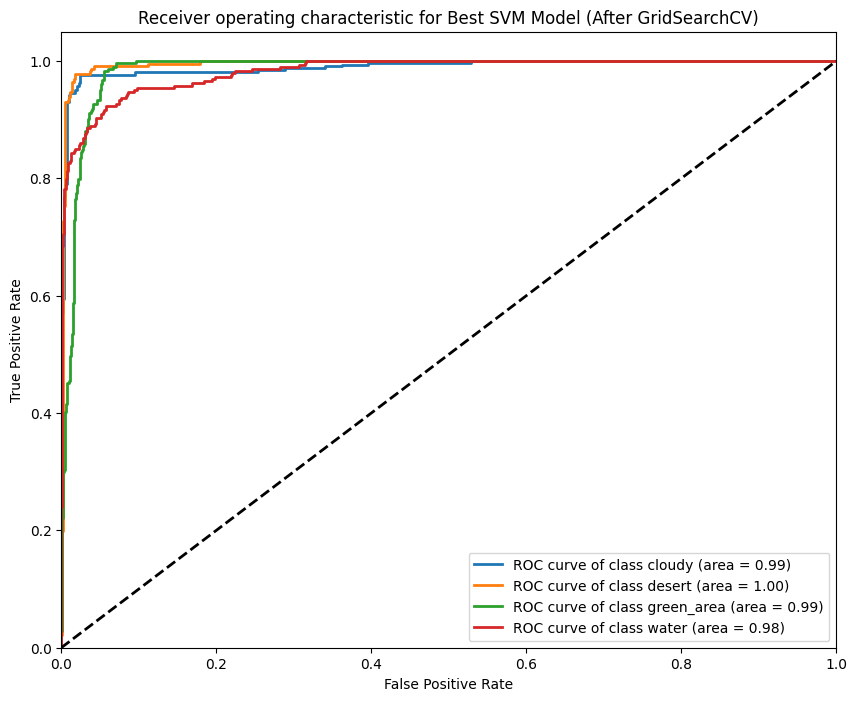

In [61]:
# AUROC Curve for SVM (After GridSearchCV)
label_proba_svm_best = best_svm_model.predict_proba(image_test_svm)

# Binarize the true test labels for SVM
# n_classes is already defined earlier based on the number of unique classes
y_test_bin_svm = label_binarize(label_test_svm, classes=np.arange(n_classes))


plt.figure(figsize=(10, 8))
fpr_svm_best = dict()
tpr_svm_best = dict()
roc_auc_svm_best = dict()

for i in tqdm(range(n_classes), desc="Calculating ROC for Best SVM"):
    fpr_svm_best[i], tpr_svm_best[i], _ = roc_curve(y_test_bin_svm[:, i], label_proba_svm_best[:, i])
    roc_auc_svm_best[i] = auc(fpr_svm_best[i], tpr_svm_best[i])
    plt.plot(fpr_svm_best[i], tpr_svm_best[i], lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'.format(class_names[i], roc_auc_svm_best[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for Best SVM Model (After GridSearchCV)')
plt.legend(loc="lower right")
print('\n')
plt.show()

In [62]:
# AUC for SVM (After GridSearchCV)
print("AUC for each class (Best SVM Model - After GridSearchCV):")
for i in range(n_classes):
    print(f"Class {class_names[i]}: {roc_auc_svm_best[i]:.4f}")

AUC for each class (Best SVM Model - After GridSearchCV):
Class cloudy: 0.9900
Class desert: 0.9953
Class green_area: 0.9853
Class water: 0.9826


Calculating AUPR for Best SVM: 100%|██████████| 4/4 [00:00<00:00, 242.06it/s]

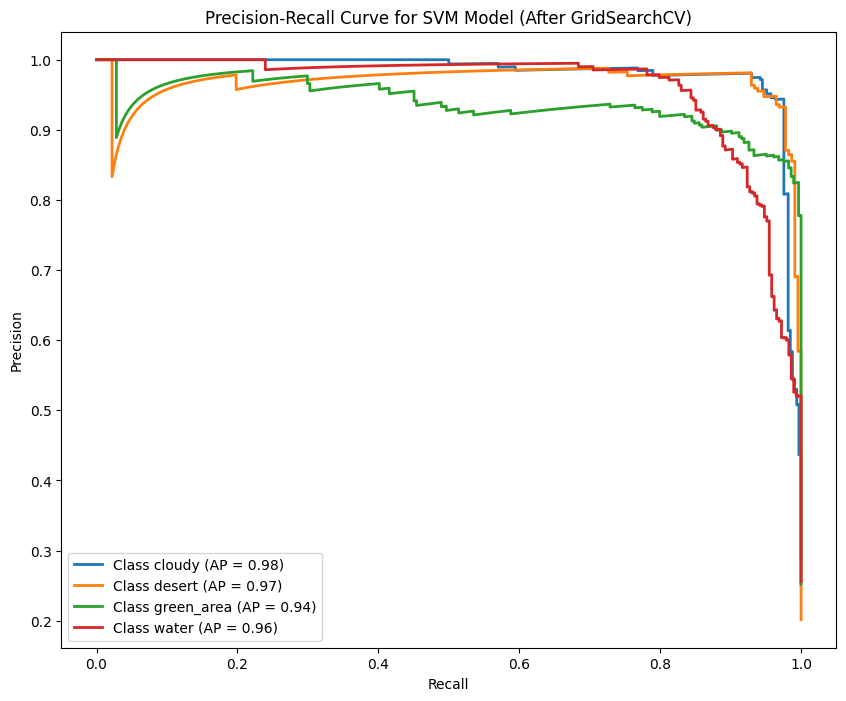

In [63]:
# AUPR Curve for SVM (After GridSearchCV)
plt.figure(figsize=(10, 8))
average_precision_svm_best = dict()

for i in tqdm(range(n_classes), desc="Calculating AUPR for Best SVM"):
    precision, recall, _ = precision_recall_curve(y_test_bin_svm[:, i], label_proba_svm_best[:, i])
    average_precision_svm_best[i] = average_precision_score(y_test_bin_svm[:, i], label_proba_svm_best[:, i])
    plt.plot(recall, precision, lw=2, label='Class {0} (AP = {1:0.2f})'.format(class_names[i], average_precision_svm_best[i]))

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve for SVM Model (After GridSearchCV)")
plt.legend(loc="lower left")
print('\n')
plt.show()

In [64]:
# Average Precision for SVM (After GridSearchCV)
print("Average Precision for each class (Best SVM Model - After GridSearchCV):")
for i in range(n_classes):
    print(f"Class {class_names[i]}: {average_precision_svm_best[i]:.4f}")

Average Precision for each class (Best SVM Model - After GridSearchCV):
Class cloudy: 0.9822
Class desert: 0.9687
Class green_area: 0.9381
Class water: 0.9601


In [65]:
# Top-K Accuracy for SVM (After GridSearchCV)
top1_acc_svm_best = top_k_accuracy_score(label_test_svm, label_proba_svm_best, k=1)
top5_acc_svm_best = top_k_accuracy_score(label_test_svm, label_proba_svm_best, k=min(5, n_classes))

print("Top-1 Accuracy for SVM (After GridSearchCV):", top1_acc_svm_best)
print(f"Top-{min(5, n_classes)} Accuracy for SVM (After GridSearchCV):", top5_acc_svm_best)

Top-1 Accuracy for SVM (After GridSearchCV): 0.9263531499556344
Top-4 Accuracy for SVM (After GridSearchCV): 1.0


# Results and Discussion

In [66]:
# Compare accuracies of different models
model_accuracies = {
    "KMeans with PCA": kmeans_pca_acc,
    "SVM (Before GridSearchCV)": svm_acc_before,
    "Best SVM Model (After GridSearchCV)": svm_acc,
    "CNN": cnn_acc,
    "VGG16 (Pre-finetune)": vgg_acc,
    "VGG16 (Post-finetune)": vgg_finetune_acc
}

# Find the model with the highest accuracy
best_model_name = max(model_accuracies, key=model_accuracies.get)
best_model_accuracy = model_accuracies[best_model_name]


print(f"The model with the best accuracy is: {best_model_name} with an accuracy of {best_model_accuracy:.4f}")

The model with the best accuracy is: VGG16 (Post-finetune) with an accuracy of 0.9938


In [67]:
# Filter out None values for plots that cannot include KMeans + PCA
def filter_none_values(data_dict):
    return {k: v for k, v in data_dict.items() if v is not None}

# Calculate mean AUC for applicable models
mean_roc_auc_svm_best = np.mean(list(roc_auc_svm_best.values())) if roc_auc_svm_best else None
mean_roc_auc_cnn = np.mean(list(roc_auc_cnn.values())) if roc_auc_cnn else None
mean_roc_auc_vgg = np.mean(list(roc_auc_vgg.values())) if roc_auc_vgg else None

auc_scores = {
    "KMeans with PCA": None, # KMeans does not provide probabilities for AUC calculation
    "Best SVM Model (After GridSearchCV)": mean_roc_auc_svm_best,
    "CNN": mean_roc_auc_cnn,
    "VGG16 (Post-finetune)": mean_roc_auc_vgg,
}

# Calculate mean Average Precision for applicable models
mean_average_precision_svm_best = np.mean(list(average_precision_svm_best.values())) if average_precision_svm_best else None
mean_average_precision_cnn = np.mean(list(average_precision_cnn.values())) if average_precision_cnn else None
mean_average_precision_vgg = np.mean(list(average_precision_vgg.values())) if average_precision_vgg else None

average_precision_scores = {
    "KMeans with PCA": None, # KMeans does not provide probabilities for AUPR calculation
    "Best SVM Model (After GridSearchCV)": mean_average_precision_svm_best,
    "CNN": mean_average_precision_cnn,
    "VGG16 (Post-finetune)": mean_average_precision_vgg,
}

# Collect Top-1 accuracies
top1_accuracies = {
    "KMeans with PCA": kmeans_pca_acc, # Accuracy for KMeans is equivalent to Top-1
    "Best SVM Model (After GridSearchCV)": top1_acc_svm_best,
    "CNN": top1_acc_cnn,
    "VGG16 (Post-finetune)": top1_acc_vgg,
}

# For Top-K Accuracy
top_k_val = n_classes
topk_accuracies = {
    "KMeans + PCA": None, # KMeans does not provide probabilities for Top-K beyond Top-1
    # Use the correct test labels and probabilities for the Simple CNN
    "CNN": top_k_accuracy_score(label_test, cnn_proba, k=top_k_val),
    # Use the correct test labels and probabilities for VGG16
    "VGG16 (Post-finetune)": top_k_accuracy_score(label_test, vgg_proba, k=top_k_val),
    "SVM (Post-GridSearchCV)": top_k_accuracy_score(label_test_svm, label_proba_svm_best, k=top_k_val),
}

# Plotting helper
def plot_metric_comparison(metric_dict, title, ylabel, best_model_name=None):
    metric_dict = filter_none_values(metric_dict)
    plt.figure(figsize=(10, 6))

    # Define colors: green for the best model, skyblue for others
    colors = ['skyblue' if model != best_model_name else 'green' for model in metric_dict.keys()]
    bars = sns.barplot(x=list(metric_dict.keys()), y=list(metric_dict.values()), palette=colors)

    for i, val in enumerate(metric_dict.values()):
        plt.text(i, val + 0.01, f"{val:.4f}", ha='center', va='bottom', fontsize=10)

    plt.title(title)
    plt.ylabel(ylabel)
    plt.ylim(0, 1.05)
    plt.xticks(rotation=15)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()


As shown in the results below, the KMeans with PCA method achieved an accuracy of 59.12%. This is expected, as KMeans is an unsupervised algorithm and not designed specifically for classification tasks. Although PCA helped reduce the number of features and remove noise, KMeans was still limited in its ability to group data points according to the actual class labels, especially given the complex nature of satellite images.

The Support Vector Machine (SVM) model performed well, reaching 91.04% accuracy before tuning. After using GridSearchCV to find the best hyperparameters, the accuracy improved slightly to 92.72%. This shows that SVM is a strong traditional machine learning method, particularly when the data is clean and structured. However, its performance was still lower than that of deep learning models.

The custom Convolutional Neural Network (CNN) achieved 97.78% accuracy. This demonstrates the advantage of CNNs in processing image data, as they can automatically learn important features like textures and shapes. The CNN was specifically built for this dataset, which helped it perform better than the classical methods.

The VGG16 model initially performed well, with an accuracy of 96.63%. After fine-tuning, optimizing it using RandomSearchCV and suing weights from ImageNey, the accuracy improved to 99.38%. This shows the power of transfer learning—when a pre-trained model is adjusted to a specific task, it can achieve near perfect results.

In conclusion, the results clearly show that deep learning models, especially fine-tuned pre-trained networks like VGG16, perform best on satellite image classification. While traditional models like SVM are still effective, deep learning provides a significant advantage when handling complex image data.

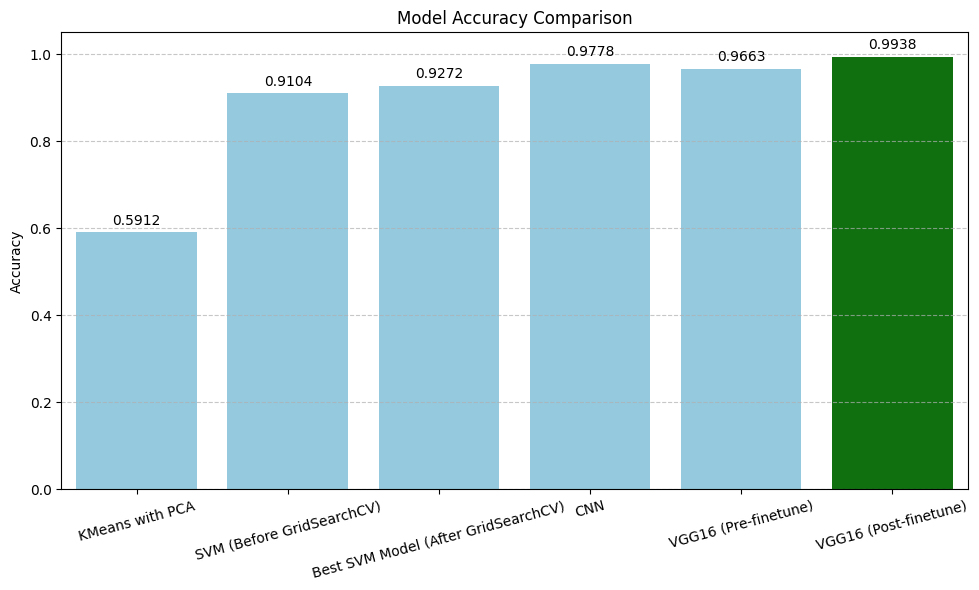

In [68]:
plot_metric_comparison(model_accuracies, "Model Accuracy Comparison", "Accuracy", best_model_name=best_model_name)

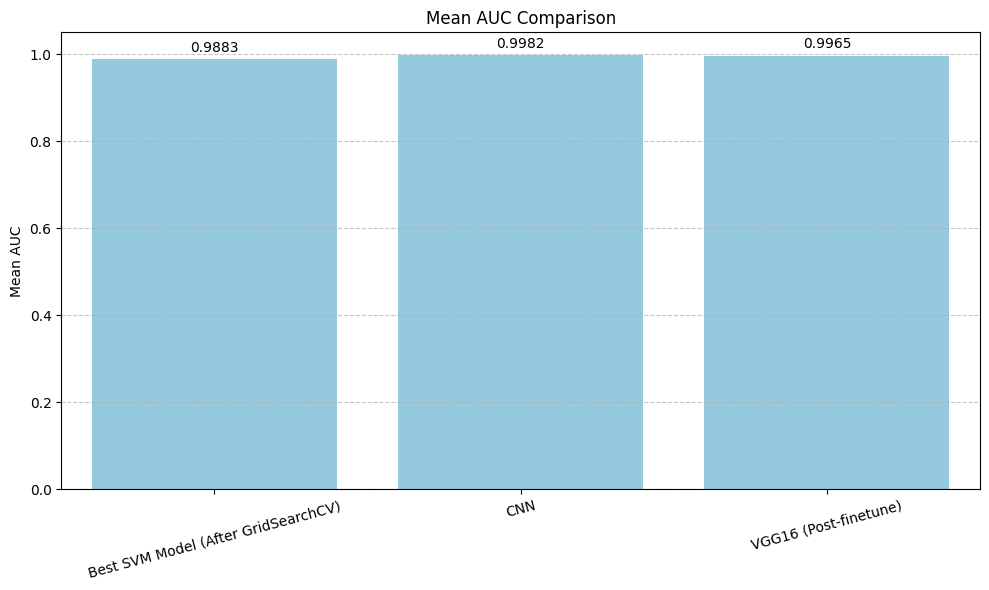

In [69]:
plot_metric_comparison(auc_scores, "Mean AUC Comparison", "Mean AUC")

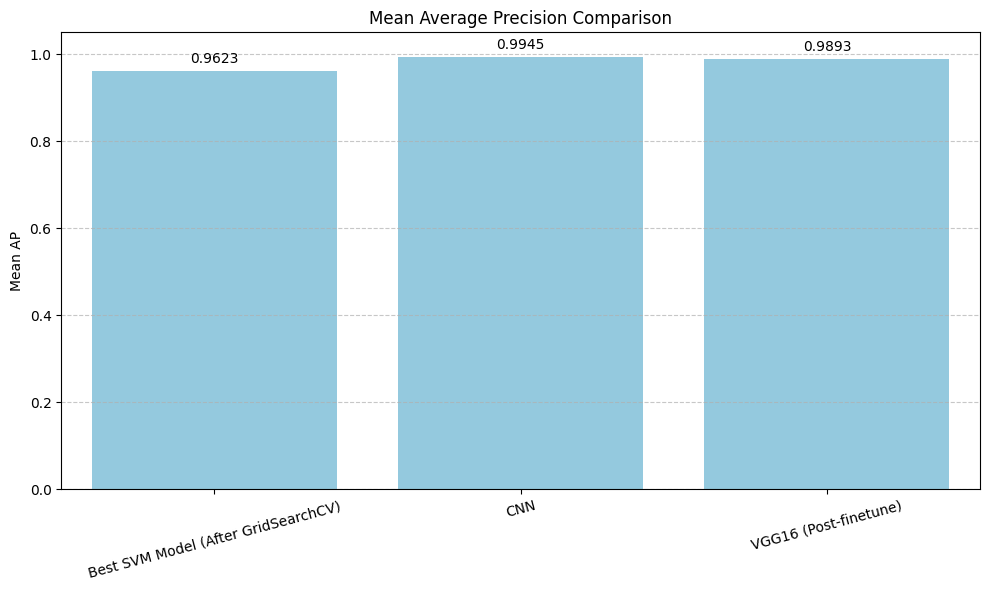

In [70]:
plot_metric_comparison(average_precision_scores, "Mean Average Precision Comparison", "Mean AP")

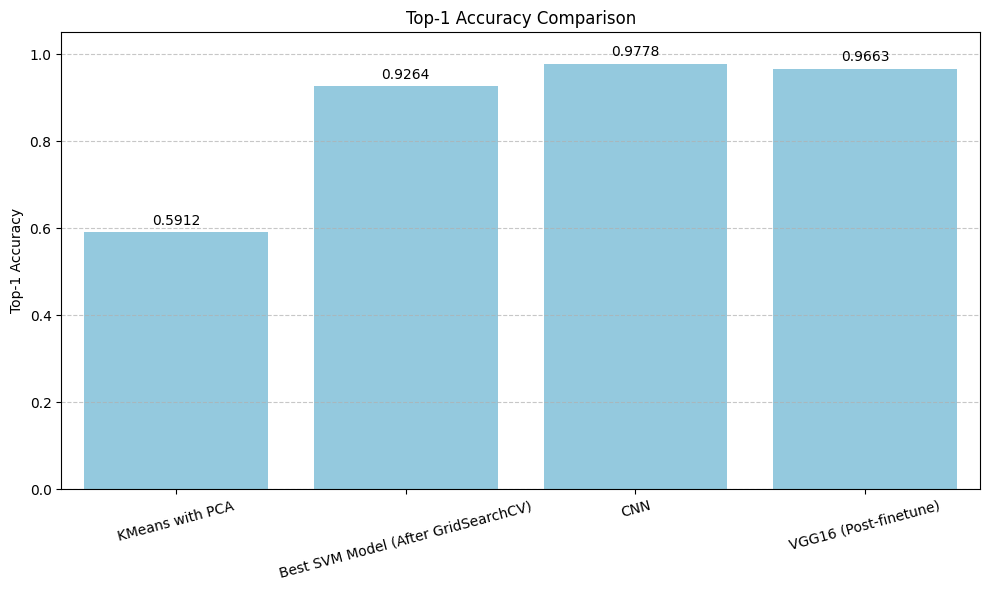

In [71]:
plot_metric_comparison(top1_accuracies, "Top-1 Accuracy Comparison", "Top-1 Accuracy")

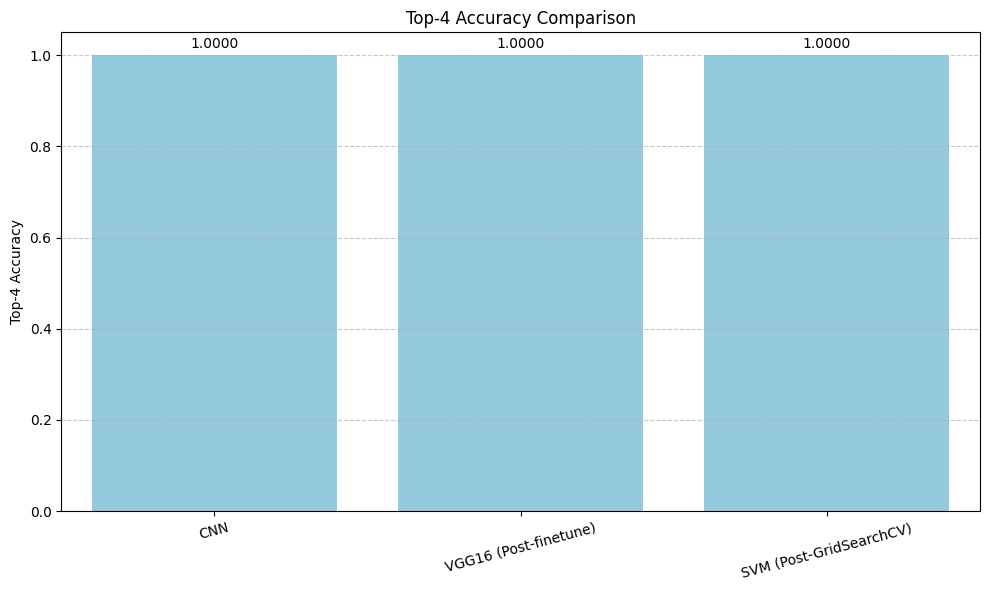

In [72]:
plot_metric_comparison(topk_accuracies, f"Top-{top_k_val} Accuracy Comparison", f"Top-{top_k_val} Accuracy")

# Sample Results

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 962ms/step
Displaying sample results for the best model: VGG16 (Post-finetune)




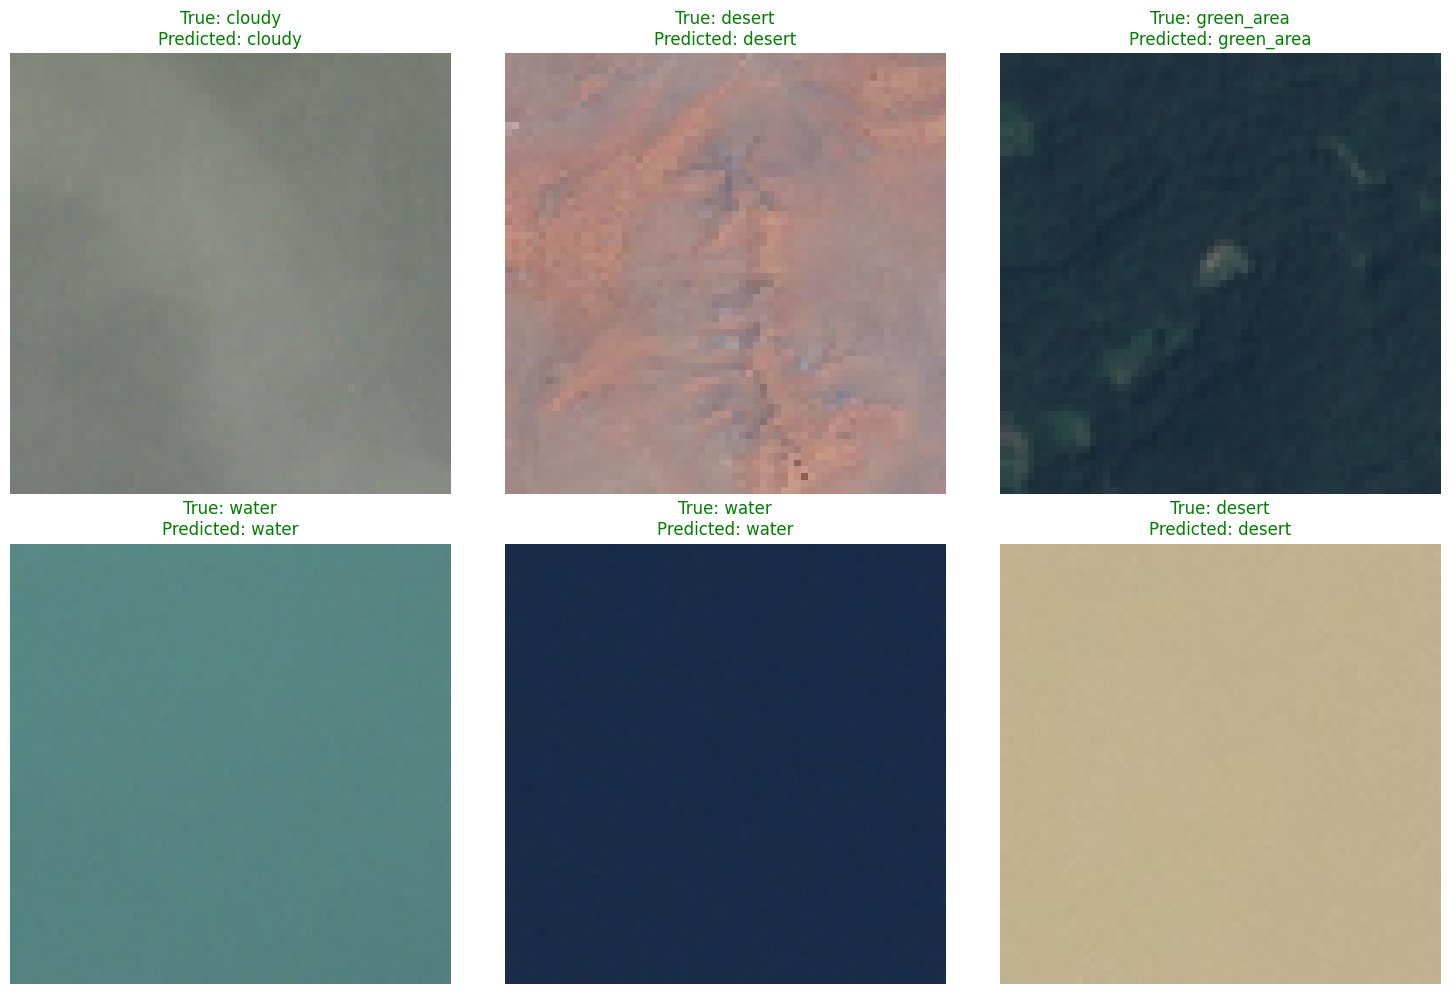

In [73]:
# Find the index of the best model from the test set
if best_model_name == "KMeans with PCA":
    # For KMeans, we don't have a clear 'test set' prediction in the same way
    # We can show samples from the entire dataset with their inferred labels
    print(f"\nDisplaying sample results for the best model: {best_model_name}")
    # Infer labels on the entire dataset
    inferred_labels = infer_labels(label, clusters_pca)

    # Get 6 random indices from the entire dataset
    random_indices = np.random.choice(len(image), 6, replace=False)

    plt.figure(figsize=(15, 10))
    for i, idx in enumerate(random_indices):
        plt.subplot(2, 3, i + 1)
        plt.imshow(image[idx])
        correct = label[idx] == inferred_labels[idx]
        color = 'green' if correct else 'red'
        plt.title(f"True: {class_names[label[idx]]}\nPredicted: {class_names[inferred_labels[idx]]}",
                  color=color)
        plt.axis('off')
    plt.tight_layout()
    plt.show()

elif best_model_name == "Best SVM Model (After GridSearchCV)":
    # Get 6 random indices from the test set
    random_indices_test = np.random.choice(len(image_test_svm), 6, replace=False)
    # Get corresponding indices in the original unflattened test set (image_test) - Approximation
    random_indices_test_orig = random_indices_test

    predicted_labels = best_svm_model.predict(image_test_svm[random_indices_test])
    true_labels = label_test_svm[random_indices_test]


    print(f"\nDisplaying sample results for the best model: {best_model_name}")
    plt.figure(figsize=(15, 10))
    for i, idx in enumerate(random_indices_test_orig):
        plt.subplot(2, 3, i + 1)
        # Use the corresponding image from the unflattened test set
        plt.imshow(image_test[idx])
        correct = true_labels[i] == predicted_labels[i]
        color = 'green' if correct else 'red'
        plt.title(f"True: {class_names[true_labels[i]]}\nPredicted: {class_names[predicted_labels[i]]}",
                  color=color)
        plt.axis('off')
    plt.tight_layout()
    plt.show()


elif best_model_name == "CNN":
    # Get 6 random indices from the test set (used for DL models)
    random_indices_test = np.random.choice(len(image_test), 6, replace=False)

    # Predict the labels for these samples
    predicted_labels = cnn_model.predict(image_test[random_indices_test]).argmax(axis=1)
    true_labels = label_test[random_indices_test]

    print(f"\nDisplaying sample results for the best model: {best_model_name}")
    plt.figure(figsize=(15, 10))
    for i, idx in enumerate(random_indices_test):
        plt.subplot(2, 3, i + 1)
        plt.imshow(image_test[idx]) # Use the images from the DL test set
        correct = true_labels[i] == predicted_labels[i]
        color = 'green' if correct else 'red'
        plt.title(f"True: {class_names[true_labels[i]]}\nPredicted: {class_names[predicted_labels[i]]}",
                  color=color)
        plt.axis('off')
    plt.tight_layout()
    plt.show()

elif best_model_name == "VGG16 (Post-finetune)":
    # Get 6 random indices from the test set (used for DL models)
    random_indices_test = np.random.choice(len(image_test), 6, replace=False)

    # Predict the labels for these samples
    predicted_labels = model_vgg.predict(image_test[random_indices_test]).argmax(axis=1)
    true_labels = label_test[random_indices_test]

    print(f"Displaying sample results for the best model: {best_model_name}")
    plt.figure(figsize=(15, 10))
    for i, idx in enumerate(random_indices_test):
        plt.subplot(2, 3, i + 1)
        plt.imshow(image_test[idx]) # Use the images from the DL test set
        correct = true_labels[i] == predicted_labels[i]
        color = 'green' if correct else 'red'
        plt.title(f"True: {class_names[true_labels[i]]}\nPredicted: {class_names[predicted_labels[i]]}",
                  color=color)
        plt.axis('off')
    plt.tight_layout()
    print('\n')
    plt.show()

else:
    print(f"Sample display not implemented for model: {best_model_name}")

# Conclusion

Based on a thorough evaluation using accuracy, AUROC, and AUPR metrics, the deep learning models consistently outperformed traditional machine learning approaches. Among all models, the fine-tuned VGG16 achieved the highest classification accuracy and strongest discriminative ability on the test dataset. This highlights the effectiveness of transfer learning and fine-tuning, as pre-trained deep learning architectures are capable of learning rich, hierarchical features from image data and adapting them to specific tasks.

The custom CNN model also performed well, demonstrating the value of building deep learning models tailored to the dataset. In contrast, the KMeans with PCA method, being unsupervised, served primarily as a baseline. While it helped uncover natural groupings within the data, it was not optimized for supervised classification tasks.

The SVM model, even with hyperparameter tuning, was constrained by the need to flatten image inputs, which removes important spatial information. Although it showed strong performance among traditional methods, it fell short of the capabilities offered by convolutional models.

Overall, the results clearly indicate that for satellite image classification, deep learning models—particularly those utilizing transfer learning—offer the best performance. The evaluation provided meaningful insights into the strengths and limitations of each approach, supporting the conclusion that deep learning is the most suitable strategy for this task.

# References

Mountrakis, G., Im, J. and Ogole, C. (2010) Support Vector Machines in remote sensing: A Review, ISPRS Journal of Photogrammetry and Remote Sensing. Available at: https://www.sciencedirect.com/science/article/pii/S0924271610001140#aep-abstract-id8 (Accessed: 25 April 2025).

Jain, A.K. (2009) Data clustering: 50 years beyond K-means, Pattern Recognition Letters. Available at: https://www.sciencedirect.com/science/article/pii/S0167865509002323#aep-abstract-id22 (Accessed: 25 April 2025).

TensorFlow (2024) Introduction to the Keras Tuner , TensorFlow. Available at: https://www.tensorflow.org/tutorials/keras/keras_tuner (Accessed: 30 April 2025).

scikit-learn (no date) User guide, scikit. Available at: https://scikit-learn.org/stable/user_guide.html# (Accessed: 02 May 2025).